#Keep Alive Section

In [ ]:
import requests
import time

while True:
    try:
        requests.get('https://www.google.com')
        print("Kept alive.")
    except:
        print("Failed to keep alive.")
    time.sleep(600)

Kept alive.


KeyboardInterrupt: 

# Drive mount and library import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import glob
import numpy as np

from string import ascii_letters
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from skimage.util.shape import view_as_blocks
import openpyxl
from openpyxl import Workbook


# RGB analysis and dataframe manipulation

In [ ]:
'''
folder_path = '/content/drive/MyDrive/Yisha/MNP/*20230602-0713_Commercial plastics_5samples+4lights+no&12filters'
datasetsavename = 'CommercialPlastics_splitviews.csv'

folder_path = '/content/drive/MyDrive/Yisha/MNP/Dry sieve less37um glass slide/PS10-12'
datasetsavename = 'PS10-12.csv'

folder_path = '/content/drive/MyDrive/Yisha/MNP/Glass slide_Spray less37um/LDPE'
datasetsavename = 'LDPEby09272023.csv'
'''
PlasticType = ['LDPE', 'Nylon', 'PET', 'PMMA', 'PS', 'PVC']
#Folder = '/content/drive/MyDrive/Yisha/MNP/Glass slide_Spray less37um/'
Folder = '/content/drive/MyDrive/Yisha/MNP/Glass slide_Spray larger37um'
i=1
folder_path = Folder + PlasticType[i] +'/'
datasetsavename = Folder + 'OstuThreshold/' + PlasticType[i] + '.csv'

##Ver1
- Region of interest (particle area) is picked by Otsu's thresholding for each picture --> a binary array where selected pixel is true
- The image is split into 9 blocks and each block gives RGB mean values.
- Then RGB values from 52 pictures of one view are contacted together, and normalized by one color channel.

In [ ]:
def SplitRGBMean(image_path, SplitNum = 3):
    '''Split the image and calculate the RGB value for each block'''
    #Overall threshold in grayscale
    original = plt.imread(image_path)
    image_gray = rgb2gray(original)
    thresh = threshold_otsu(image_gray)
    binary = image_gray > thresh  # Binary is a image mask (boolean)
    [row, col] = binary.shape

    #Split binary into blocks
    block_shape=(int(row/SplitNum), int(col/SplitNum)) #needs to be a tuple
    Blocks_binary = view_as_blocks(binary, block_shape = block_shape)

    #Get RGB value for each blocks
    image_rgb = original.astype(np.uint8) #turn image into RGB type
    Data = np.ndarray(shape=(SplitNum*SplitNum,4)) #3 columns represent RGB channels + 1 column represent blocks
    #EmptyImages=[] #records of which blocks have no particles
    for channel in range(3):
        #take one color channel of the image and split
        Blocks = view_as_blocks(image_rgb[...,channel], block_shape = block_shape)
        for i in range(SplitNum):
            for j in range(SplitNum):
                B = Blocks_binary[i,j]
                n = i*SplitNum+j
                Data[n, 3] = n #Record which block it is
                if B[B==True].size>0:
                    A = Blocks[i,j]
                    Data[n,channel] = int(100*np.mean(A[B]))/100
                else: Data[n,channel] = np.nan

    return(Data)

In [ ]:
#PlasticType = ['LDPE', 'Nylon', 'PET', 'PMMA', 'PS', 'PVC']
PlasticType = ['Clay']
Folder = '/content/drive/MyDrive/Yisha/MNP/Glass slide_Dry sieve less37um/'
#Folder = '/content/drive/MyDrive/Yisha/MNP/Glass slide_Spray less37um/'
subFolder = 'OstuThreshold_Zeros/' #'OstuThreshold/'

for i in range(len(PlasticType)):
  folder_path = Folder + PlasticType[i] +'/'
  datasetsavename = Folder + subFolder + PlasticType[i] + '.csv'
  '''Split version, including RGB calculation and file save'''
  '''The input path needs to be modified for lab desktop'''

  Data = pd.DataFrame()
  # Get the files
  files = os.listdir(folder_path)
  #sort the files by modified time (note: st_ctime is created time)
  files.sort(key=lambda x: os.stat(os.path.join(folder_path, x)).st_mtime)

  for num, filename in enumerate(files):
      if filename.endswith('.jpg'):
          image_path = os.path.join(folder_path, filename)
          namesplit = filename[:-4].split("_")[:4] #remove the last 4 character (.jpg)

          #Split all images with 3*3 grid
          RGBdata = SplitRGBMean(image_path, 3)
          RGBData_dataframe = pd.DataFrame(RGBdata, columns = ['R', 'G', 'B', 'Block'])

          #Add other info
          newcol = ['Sample', 'Light', 'Filter', 'Repeat']
          for i in range(4):
              RGBData_dataframe[newcol[i]] = namesplit[i]
          #print('Results from', filename)
          #display(RGBData_dataframe)

          #Merge results into one dataframe
          Data = pd.concat([Data, RGBData_dataframe], ignore_index=True)

          if num%52==0: print(num+1, f"Threshold RGB mean for {filename}: Done!")
          #display(Data)

  #print('Results have been saved!')
  display(Data)


  #check any block is empty
  print(Data.loc[Data.isnull().any(axis=1),:])


  '''ImageSplit, NoReadProcess Version'''
  #DataLabeled = Data.dropna() #no nan, no empty block info
  DataLabeled = Data.fillna(0) #empty block info =0

  # RGB normalization
  LightOption = ['G', 'B', 'UV', 'R'] # light source
  LightRBGNorm = ['G', 'B', 'B', 'R'] # for each light, which RGB channel is for normalization
  LightName = ['Green', 'Blue', 'UV', 'Red'] # for each light, which is for creating the figure

  fignum=0
  df_merge=pd.DataFrame()

  # Loop in different lights
  for k in range(len(LightOption)):
      df = pd.DataFrame()
      df = DataLabeled[(DataLabeled['Light'] == LightOption[k])]
      print('Analyzing:', LightName[k])
      #display(df)
      RatioList=[]

      # RGB normalization
      for i in ['R','G','B']:
          denominator = LightRBGNorm[k]
          if i!=denominator:
              colname = LightOption[k] +'_' + i + '/'+denominator
              #df[colname] = df[i]/df[denominator]
              df.loc[:, colname] = df[i]/df[denominator]
              RatioList.append(colname)
      print('Done: RGB ratio versus', denominator, 'has been calculated!')
      #display(df)

      # extract parameter columns
      df = (df.loc[:,['Sample', 'Filter', 'Repeat', 'Block', *RatioList]]  #columns=sample, filter, repeat, and two calculated parameters
            .reset_index(drop=True)
      )
      #display(df)

      #if k==1:break
      # merge the RGB results by sample
      if df_merge.empty:
          df_merge = df
      else:
          df_merge = df_merge.merge(df, on=['Sample', 'Filter', 'Repeat', 'Block'])
      #display(df_merge)

  df_merge = df_merge.pivot_table(index=['Sample', 'Repeat', 'Block'], columns='Filter')
  df_merge.columns = ["_".join((i,j)) for i,j in df_merge.columns]
  df_merge = (df_merge.reset_index(names=['Sample', 'Repeat', 'Block'])
              .drop(columns=['Block'])
              .rename(columns={'Sample':'Class'})
              #.dropna() #no na
              .fillna(0)
              .reset_index(drop=True)
            )


  #df_merge = df_merge.drop(columns=['Repeat']) Wanna save the Repeat(View) info
  df_merge['Repeat'] = df_merge['Repeat'].apply(pd.to_numeric)
  df_merge = (df_merge.rename(columns={'Repeat':'View'})
              .sort_values(by=['View'])
              .reset_index(drop=True)
              )

  display(df_merge)
  #Export results to csv
  if not os.path.exists(Folder+subFolder):
      # Create the subfolder.
      os.mkdir(Folder+subFolder)
  df_merge.to_csv(datasetsavename, index=False)

1 Threshold RGB mean for Clay_R_N_1.jpg: Done!
53 Threshold RGB mean for Clay_R_N_2.jpg: Done!
105 Threshold RGB mean for Clay_R_N_3.jpg: Done!
157 Threshold RGB mean for Clay_R_N_4.jpg: Done!
209 Threshold RGB mean for Clay_R_N_5.jpg: Done!
261 Threshold RGB mean for Clay_R_N_6.jpg: Done!
313 Threshold RGB mean for Clay_R_N_7.jpg: Done!
365 Threshold RGB mean for Clay_R_N_8.jpg: Done!
417 Threshold RGB mean for Clay_R_N_9.jpg: Done!
469 Threshold RGB mean for Clay_R_N_10.jpg: Done!
521 Threshold RGB mean for Clay_R_N_11.jpg: Done!
573 Threshold RGB mean for Clay_R_N_12.jpg: Done!


,R,G,B,Block,Sample,Light,Filter,Repeat
0,213.48,118.77,126.54,0.0,Clay,R,N,1
1,208.01,115.50,126.70,1.0,Clay,R,N,1
2,204.57,105.20,117.03,2.0,Clay,R,N,1
3,207.34,110.98,120.21,3.0,Clay,R,N,1
4,217.41,118.86,127.57,4.0,Clay,R,N,1
...,...,...,...,...,...,...,...,...
5611,93.43,87.12,144.60,4.0,Clay,UV,l,12
5612,87.65,82.25,138.96,5.0,Clay,UV,l,12
5613,83.98,79.86,134.44,6.0,Clay,UV,l,12
5614,87.75,83.33,137.12,7.0,Clay,UV,l,12


Empty DataFrame
Columns: [R, G, B, Block, Sample, Light, Filter, Repeat]
Index: []
Analyzing: Green
Done: RGB ratio versus G has been calculated!
Analyzing: Blue
Done: RGB ratio versus B has been calculated!
Analyzing: UV
Done: RGB ratio versus B has been calculated!
Analyzing: Red
Done: RGB ratio versus R has been calculated!


<ipython-input-5-bfe534f6f47c>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, colname] = df[i]/df[denominator]
<ipython-input-5-bfe534f6f47c>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, colname] = df[i]/df[denominator]
<ipython-input-5-bfe534f6f47c>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,Class,View,B_G/B_N,B_G/B_a,B_G/B_b,B_G/B_c,B_G/B_d,B_G/B_e,B_G/B_f,B_G/B_g,...,UV_R/B_c,UV_R/B_d,UV_R/B_e,UV_R/B_f,UV_R/B_g,UV_R/B_h,UV_R/B_i,UV_R/B_j,UV_R/B_k,UV_R/B_l
0,Clay,1,0.578645,0.697156,0.829552,0.683363,0.677896,0.496873,0.765232,0.594902,...,0.522089,0.550229,0.443104,0.755833,0.508241,0.745705,0.617547,0.876267,0.593978,0.774600
1,Clay,1,0.572291,0.689546,0.847851,0.702849,0.681936,0.496838,0.764879,0.578580,...,0.476865,0.536539,0.420983,0.763941,0.493338,0.744077,0.660583,0.888356,0.585860,0.802618
2,Clay,1,0.537032,0.671929,0.819612,0.685850,0.664813,0.449622,0.736216,0.524177,...,0.452304,0.519460,0.419942,0.751352,0.469280,0.726123,0.654889,0.885226,0.565872,0.791190
3,Clay,1,0.553742,0.664611,0.825269,0.684773,0.660190,0.464480,0.737018,0.539372,...,0.493830,0.537140,0.426557,0.755009,0.490781,0.728270,0.632611,0.879170,0.565181,0.778790
4,Clay,1,0.563614,0.691506,0.829596,0.669841,0.677786,0.452711,0.753875,0.581586,...,0.489997,0.549170,0.430340,0.749922,0.501139,0.732017,0.615085,0.887057,0.582683,0.782509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,Clay,12,0.450524,0.647536,0.724908,0.621069,0.657885,0.266771,0.606981,0.405008,...,0.482658,0.695927,0.459250,0.726168,0.507295,0.724245,0.419661,0.846307,0.601416,0.646127
104,Clay,12,0.463457,0.602889,0.703281,0.576571,0.616280,0.266215,0.567422,0.344208,...,0.470639,0.695109,0.446623,0.724213,0.498265,0.716223,0.383554,0.838052,0.592899,0.639841
105,Clay,12,0.380410,0.621605,0.718027,0.619194,0.641824,0.258906,0.578286,0.390964,...,0.473278,0.698369,0.459195,0.716381,0.490994,0.713057,0.427147,0.846996,0.585942,0.619983
106,Clay,12,0.377030,0.638210,0.736610,0.633351,0.658093,0.278379,0.589407,0.392745,...,0.491893,0.705870,0.472326,0.725700,0.513314,0.711902,0.452813,0.853478,0.611771,0.651314


In [ ]:
#check any block is empty
print(Data.loc[Data.isnull().any(axis=1),:])

       R   G   B  Block Sample Light Filter Repeat
214  NaN NaN NaN    7.0   LDPE    UV      e      1
325  NaN NaN NaN    1.0   LDPE     R      i      1
343  NaN NaN NaN    1.0   LDPE     B      i      1
575  NaN NaN NaN    8.0   LDPE    UV      b      2
683  NaN NaN NaN    8.0   LDPE    UV      e      2
...   ..  ..  ..    ...    ...   ...    ...    ...
5351 NaN NaN NaN    5.0   LDPE     B      e     12
5353 NaN NaN NaN    7.0   LDPE     B      e     12
5354 NaN NaN NaN    8.0   LDPE     B      e     12
5432 NaN NaN NaN    5.0   LDPE    UV      g     12
5459 NaN NaN NaN    5.0   LDPE     B      h     12

[75 rows x 8 columns]


In [ ]:
'''ImageSplit, NoReadProcess Version'''
DataLabeled = Data.dropna()

# RGB normalization
LightOption = ['G', 'B', 'UV', 'R'] # light source
LightRBGNorm = ['G', 'B', 'B', 'R'] # for each light, which RGB channel is for normalization
LightName = ['Green', 'Blue', 'UV', 'Red'] # for each light, which is for creating the figure

fignum=0
df_merge=pd.DataFrame()

# Loop in different lights
for k in range(len(LightOption)):
    df = pd.DataFrame()
    df = DataLabeled[(DataLabeled['Light'] == LightOption[k])]
    print('Analyzing:', LightName[k])
    #display(df)
    RatioList=[]

    # RGB normalization
    for i in ['R','G','B']:
        denominator = LightRBGNorm[k]
        if i!=denominator:
            colname = LightOption[k] +'_' + i + '/'+denominator
            #df[colname] = df[i]/df[denominator]
            df.loc[:, colname] = df[i]/df[denominator]
            RatioList.append(colname)
    print('Done: RGB ratio versus', denominator, 'has been calculated!')
    #display(df)

    # extract parameter columns
    df = (df.loc[:,['Sample', 'Filter', 'Repeat', 'Block', *RatioList]]  #columns=sample, filter, repeat, and two calculated parameters
          .reset_index(drop=True)
     )
    #display(df)

    #if k==1:break
    # merge the RGB results by sample
    if df_merge.empty:
        df_merge = df
    else:
        df_merge = df_merge.merge(df, on=['Sample', 'Filter', 'Repeat', 'Block'])
    #display(df_merge)

df_merge = df_merge.pivot_table(index=['Sample', 'Repeat', 'Block'], columns='Filter')
df_merge.columns = ["_".join((i,j)) for i,j in df_merge.columns]
df_merge = (df_merge.reset_index(names=['Sample', 'Repeat', 'Block'])
            #.drop(columns=['Repeat','Block'])
            .drop(columns=['Block'])
            .rename(columns={'Sample':'Class'})
            .dropna()
            .reset_index(drop=True)
           )


#df_merge = df_merge.drop(columns=['Repeat']) Wanna save the Repeat(View) info
df_merge['Repeat'] = df_merge['Repeat'].apply(pd.to_numeric)
df_merge = (df_merge.rename(columns={'Repeat':'View'})
            .sort_values(by=['View'])
            .reset_index(drop=True)
            )

display(df_merge)
#Export results to csv
#os.makedirs(folder_path, exist_ok=True)
df_merge.to_csv(datasetsavename, index=False)

Analyzing: Green
Done: RGB ratio versus G has been calculated!
Analyzing: Blue
Done: RGB ratio versus B has been calculated!
Analyzing: UV
Done: RGB ratio versus B has been calculated!
Analyzing: Red
Done: RGB ratio versus R has been calculated!


<ipython-input-13-ca0b9030cef4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, colname] = df[i]/df[denominator]
<ipython-input-13-ca0b9030cef4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, colname] = df[i]/df[denominator]
<ipython-input-13-ca0b9030cef4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,Class,View,B_G/B_N,B_R/B_N,G_B/G_N,G_R/G_N,R_B/R_N,R_G/R_N,UV_G/B_N,UV_R/B_N
0,Nylon,1,0.804195,0.492863,0.927997,0.354783,0.687312,0.714844,0.300784,0.597152
1,Nylon,1,0.664155,0.478983,0.925491,0.335931,0.663220,0.670741,0.352979,0.503067
2,Nylon,1,0.714140,0.458958,0.947862,0.399235,0.647746,0.699227,0.521400,0.567215
3,Nylon,1,0.786378,0.481762,0.932101,0.389609,0.684323,0.726279,0.286058,0.612886
4,Nylon,1,0.741195,0.538404,0.923221,0.392744,0.675161,0.699079,0.356092,0.521719
5,Nylon,1,0.762629,0.533742,0.946643,0.434200,0.692575,0.754604,0.328745,0.531697
6,Nylon,1,0.833930,0.502065,0.944759,0.469360,0.696259,0.759435,0.366422,0.663932
7,Nylon,1,0.806397,0.598901,0.936368,0.422788,0.737317,0.743488,0.424453,0.687591
8,Nylon,1,0.784278,0.581278,0.942652,0.458995,0.721344,0.767501,0.359333,0.651670


##Ver2
- Difference to Ver1 is the thresholding method: Yen

In [ ]:
from skimage.filters import threshold_yen
from skimage.color import rgb2gray
from skimage.util import view_as_blocks


def SplitRGBMean_Yen(image_path, SplitNum):
    '''Split the image and calculate the RGB value for each block'''
    #Overall threshold in grayscale
    original = plt.imread(image_path)
    image_gray = rgb2gray(original)
    thresh = threshold_yen(image_gray)
    binary = image_gray > thresh  # Binary is a image mask (boolean)
    [row, col] = binary.shape

    #Split binary into blocks
    block_shape=(int(row/SplitNum), int(col/SplitNum)) #needs to be a tuple
    Blocks_binary = view_as_blocks(binary, block_shape = block_shape)

    #Get RGB value for each blocks
    image_rgb = original.astype(np.uint8) #turn image into RGB type
    Data = np.ndarray(shape=(SplitNum*SplitNum,4)) #3 columns represent RGB channels + 1 column represent blocks
    #EmptyImages=[] #records of which blocks have no particles
    for channel in range(3):
        #take one color channel of the image and split
        Blocks = view_as_blocks(image_rgb[...,channel], block_shape = block_shape)
        for i in range(SplitNum):
            for j in range(SplitNum):
                B = Blocks_binary[i,j]
                n = i*SplitNum+j
                Data[n, 3] = n #Record which block it is
                if B[B==True].size>0:
                    A = Blocks[i,j]
                    Data[n,channel] = int(100*np.mean(A[B]))/100
                else: Data[n,channel] = np.nan
                #else: EmptyImages.append(n)
    #Data=np.delete(Data,EmptyImages, axis=0)
    '''for Aug 30. No delete. But think of how to exp'''
    return(Data)

In [ ]:
#The roo
Folder_Path = '/content/drive/MyDrive/Yisha/MNP/Glass slide_Dry sieve less37um/'
folders = ['LDPE', 'Nylon', 'PET', 'PMMA', 'PS','PVC']

In [ ]:
'''Split version, including RGB calculation and file save'''
'''The input path needs to be modified for lab desktop'''


for folder in folders:
    folder_path = Folder_Path + folder
    # Get the files
    files = os.listdir(folder_path)
    #sort the files by modified time (note: st_ctime is created time)
    files.sort(key=lambda x: os.stat(os.path.join(folder_path, x)).st_mtime)
    Data = pd.DataFrame()
    for num, filename in enumerate(files):
        if filename.endswith('.jpg'):
            image_path = os.path.join(folder_path, filename)
            namesplit = filename[:-4].split("_")[:4] #remove the last 4 character (.jpg)

            #Split images and extract RGB value from splited blocks
            #Split all images with 3*3 grid
            RGBdata = SplitRGBMean_Yen(image_path, 3)
            RGBData_dataframe = pd.DataFrame(RGBdata, columns = ['R', 'G', 'B', 'Block'])

            #Add other info
            newcol = ['Sample', 'Light', 'Filter', 'Repeat']
            for i in range(4):
                RGBData_dataframe[newcol[i]] = namesplit[i]
            #print('Results from', filename)
            #display(RGBData_dataframe)

            #Merge results into one dataframe
            Data = pd.concat([Data, RGBData_dataframe], ignore_index=True)

            if num%52==0: print(num+1, f"Threshold RGB mean for {filename}: Done!")

    display(Data)

    '''ImageSplit, NoReadProcess Version'''
    DataLabeled = Data.dropna()

    # RGB normalization
    LightOption = ['G', 'B', 'UV', 'R'] # light source
    LightRBGNorm = ['G', 'B', 'B', 'R'] # for each light, which RGB channel is for normalization
    LightName = ['Green', 'Blue', 'UV', 'Red'] # for each light, which is for creating the figure

    fignum=0
    df_merge=pd.DataFrame()

    # Loop in different lights
    for k in range(len(LightOption)):
        df = pd.DataFrame()
        df = DataLabeled[(DataLabeled['Light'] == LightOption[k])]
        print('Analyzing:', LightName[k])
        #display(df)
        RatioList=[]

        # RGB normalization
        for i in ['R','G','B']:
            denominator = LightRBGNorm[k]
            if i!=denominator:
                colname = LightOption[k] +'_' + i + '/'+denominator
                #df[colname] = df[i]/df[denominator]
                df.loc[:, colname] = df[i]/df[denominator]
                RatioList.append(colname)
        print('Done: RGB ratio versus', denominator, 'has been calculated!')
        #display(df)

        # extract parameter columns
        df = (df.loc[:,['Sample', 'Filter', 'Repeat', 'Block', *RatioList]]  #columns=sample, filter, repeat, and two calculated parameters
              .reset_index(drop=True)
        )
        #display(df)

        #if k==1:break
        # merge the RGB results by sample
        if df_merge.empty:
            df_merge = df
        else:
            df_merge = df_merge.merge(df, on=['Sample', 'Filter', 'Repeat', 'Block'])
        #display(df_merge)

    df_merge = df_merge.pivot_table(index=['Sample', 'Repeat', 'Block'], columns='Filter')
    df_merge.columns = ["_".join((i,j)) for i,j in df_merge.columns]
    df_merge = (df_merge.reset_index(names=['Sample', 'Repeat', 'Block'])
                #.drop(columns=['Repeat','Block'])
                .drop(columns=['Block'])
                .rename(columns={'Sample':'Class'})
                .dropna()
                .reset_index(drop=True)
              )

    #df_merge = df_merge.drop(columns=['Repeat']) Wanna save the Repeat(View) info
    df_merge['Repeat'] = df_merge['Repeat'].apply(pd.to_numeric)
    df_merge = (df_merge.rename(columns={'Repeat':'View'})
                .sort_values(by=['View'])
                .reset_index(drop=True)
                )

    display(df_merge)
    #Export results to csv
    df_merge.to_csv(Folder_Path + 'YenThreshold/'+ folder +'.csv', index=False)

1 Threshold RGB mean for LDPE_R_N_1.jpg: Done!
53 Threshold RGB mean for LDPE_R_N_2.jpg: Done!
105 Threshold RGB mean for LDPE_R_N_3.jpg: Done!


/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *


157 Threshold RGB mean for LDPE_R_N_4.jpg: Done!


/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *


209 Threshold RGB mean for LDPE_R_N_5.jpg: Done!


/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *
/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *
/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *
/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *


261 Threshold RGB mean for LDPE_R_N_6.jpg: Done!


/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *
/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *
/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *
/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *
/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *
/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero en

313 Threshold RGB mean for LDPE_R_N_7.jpg: Done!


/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *
/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *
/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *
/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *


365 Threshold RGB mean for LDPE_R_N_8.jpg: Done!


/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *
/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *
/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *
/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *


417 Threshold RGB mean for LDPE_R_N_9.jpg: Done!
469 Threshold RGB mean for LDPE_R_N_10.jpg: Done!
521 Threshold RGB mean for LDPE_R_N_11.jpg: Done!


/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *
/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *


573 Threshold RGB mean for LDPE_R_N_12.jpg: Done!


/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *
/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *


,R,G,B,Block,Sample,Light,Filter,Repeat
0,251.94,177.55,154.68,0.0,LDPE,R,N,1
1,252.81,169.85,152.48,1.0,LDPE,R,N,1
2,252.70,174.66,154.18,2.0,LDPE,R,N,1
3,252.22,181.10,155.52,3.0,LDPE,R,N,1
4,253.16,168.47,156.64,4.0,LDPE,R,N,1
...,...,...,...,...,...,...,...,...
5611,144.85,135.70,238.21,4.0,LDPE,UV,l,12
5612,144.48,132.32,239.71,5.0,LDPE,UV,l,12
5613,145.49,134.25,239.68,6.0,LDPE,UV,l,12
5614,143.10,132.18,237.99,7.0,LDPE,UV,l,12


Analyzing: Green
Done: RGB ratio versus G has been calculated!
Analyzing: Blue
Done: RGB ratio versus B has been calculated!
Analyzing: UV
Done: RGB ratio versus B has been calculated!
Analyzing: Red
Done: RGB ratio versus R has been calculated!


<ipython-input-17-69b3afa59278>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, colname] = df[i]/df[denominator]
<ipython-input-17-69b3afa59278>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, colname] = df[i]/df[denominator]
<ipython-input-17-69b3afa59278>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,Class,View,B_G/B_N,B_G/B_a,B_G/B_b,B_G/B_c,B_G/B_d,B_G/B_e,B_G/B_f,B_G/B_g,...,UV_R/B_c,UV_R/B_d,UV_R/B_e,UV_R/B_f,UV_R/B_g,UV_R/B_h,UV_R/B_i,UV_R/B_j,UV_R/B_k,UV_R/B_l
0,LDPE,1,0.933257,0.748753,0.848710,0.877528,0.780452,0.967212,0.709653,0.960547,...,0.783952,0.927330,0.901761,0.813178,0.957670,0.781355,0.249052,0.929554,0.868366,0.678110
1,LDPE,1,0.924739,0.669578,0.833923,0.864202,0.723495,0.954753,0.677669,0.944420,...,0.722406,0.875780,0.845216,0.741441,0.943359,0.732722,0.319567,0.934095,0.825594,0.633368
2,LDPE,1,0.924472,0.700850,0.816970,0.864218,0.735307,0.947293,0.677562,0.944954,...,0.727730,0.890192,0.886510,0.725548,0.947519,0.734175,0.350735,0.931680,0.823783,0.643229
3,LDPE,1,0.939157,0.735537,0.859070,0.886970,0.774834,0.958590,0.698529,0.955607,...,0.781927,0.926272,0.911291,0.787194,0.950344,0.771106,0.264825,0.920184,0.854396,0.671026
4,LDPE,1,0.916568,0.692190,0.848511,0.861106,0.733452,0.950765,0.681357,0.943390,...,0.735253,0.899565,0.882471,0.729031,0.948343,0.747161,0.308611,0.925797,0.833752,0.647534
5,LDPE,1,0.923789,0.680913,0.836341,0.870275,0.726450,0.945530,0.678564,0.947431,...,0.723943,0.879412,0.864706,0.706776,0.943244,0.720233,0.355920,0.927313,0.830189,0.640856
6,LDPE,1,0.932678,0.733710,0.852756,0.880944,0.766517,0.958491,0.712494,0.959830,...,0.795850,0.930314,0.907134,0.749504,0.954155,0.760832,0.238052,0.909107,0.862858,0.676764
7,LDPE,1,0.920548,0.668083,0.851209,0.855369,0.719501,0.940051,0.665887,0.942394,...,0.741410,0.881594,0.865765,0.672742,0.946658,0.719749,0.312720,0.921808,0.834628,0.637451
8,LDPE,1,0.928946,0.690337,0.839761,0.865324,0.739934,0.934807,0.677747,0.943509,...,0.739057,0.880535,0.892039,0.664047,0.948270,0.715510,0.368237,0.920525,0.831895,0.643757
9,LDPE,2,0.922027,0.591789,0.782469,0.602685,0.515420,0.812045,0.548481,0.741305,...,0.638326,0.867311,0.831255,0.887647,0.883765,0.702884,0.476225,0.909306,0.747372,0.568157


1 Threshold RGB mean for Nylon_R_N_1.jpg: Done!
53 Threshold RGB mean for Nylon_R_N_2.jpg: Done!
105 Threshold RGB mean for Nylon_R_N_3.jpg: Done!
157 Threshold RGB mean for Nylon_R_N_4.jpg: Done!
209 Threshold RGB mean for Nylon_R_N_5.jpg: Done!
261 Threshold RGB mean for Nylon_R_N_6.jpg: Done!


/usr/local/lib/python3.10/dist-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *


313 Threshold RGB mean for Nylon_R_N_8.jpg: Done!


KeyboardInterrupt: ignored

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
A=Data[Data['Sample']=='LDPE']
display(A)
#check any block is empty
print(A.loc[A.isnull().any(axis=1),:])

,R,G,B,Block,Sample,Light,Filter,Repeat
0,251.94,177.55,154.68,0.0,LDPE,R,N,1
1,252.81,169.85,152.48,1.0,LDPE,R,N,1
2,252.70,174.66,154.18,2.0,LDPE,R,N,1
3,252.22,181.10,155.52,3.0,LDPE,R,N,1
4,253.16,168.47,156.64,4.0,LDPE,R,N,1
...,...,...,...,...,...,...,...,...
5611,144.85,135.70,238.21,4.0,LDPE,UV,l,12
5612,144.48,132.32,239.71,5.0,LDPE,UV,l,12
5613,145.49,134.25,239.68,6.0,LDPE,UV,l,12
5614,143.10,132.18,237.99,7.0,LDPE,UV,l,12


       R   G   B  Block Sample Light Filter Repeat
718  NaN NaN NaN    7.0   LDPE    UV      f      2
749  NaN NaN NaN    2.0   LDPE    UV      g      2
1000 NaN NaN NaN    1.0   LDPE    UV      a      3
1001 NaN NaN NaN    2.0   LDPE    UV      a      3
1006 NaN NaN NaN    7.0   LDPE    UV      a      3
...   ..  ..  ..    ...    ...   ...    ...    ...
5431 NaN NaN NaN    4.0   LDPE    UV      g     12
5432 NaN NaN NaN    5.0   LDPE    UV      g     12
5433 NaN NaN NaN    6.0   LDPE    UV      g     12
5434 NaN NaN NaN    7.0   LDPE    UV      g     12
5577 NaN NaN NaN    6.0   LDPE    UV      k     12

[262 rows x 8 columns]


In [ ]:
df_merge.reset_index(names=['Sample', 'Repeat', 'Block'])

In [ ]:
#Export results to csv
os.makedirs(folder_path, exist_ok=True)
df_merge.to_csv(datasetsavename, index=False)

In [ ]:
df_merge_NameReplaced = (df_merge.replace(to_replace=r'PAMS', value='PA', regex=True)
                          .replace(to_replace=r'PMPMS', value='PMMA', regex=True)
                          .replace(to_replace=r'PSMS', value='PS', regex=True)
                          .replace(to_replace=r'WPEMS', value='LDPE', regex=True)
                          )
display(df_merge_NameReplaced)
df_merge_NameReplaced.to_csv(datasetsavename, index=False)

Check the dataframe manipulation after the RGBanalysis

In [ ]:
display(df_merge)
print(df_merge[df_merge.isna().any(axis=1)])

df_merge1 = df_merge.pivot_table(index=['Sample', 'Repeat', 'Block'], columns='Filter')
display(df_merge1)
print(df_merge1[df_merge1.isna().any(axis=1)])
df_merge1.columns = ["_".join((i,j)) for i,j in df_merge1.columns]
df_merge2 = (df_merge1.reset_index(names=['Sample', 'Repeat', 'Block'])
            .drop(columns=['Repeat','Block'])
            .rename(columns={"Sample":"Class"})
           )
display(df_merge2)
print(df_merge2[df_merge2.isna().any(axis=1)])

In [ ]:
print(df_merge.loc[(df_merge['Sample']=='PAMS') & (df_merge['Repeat']=='3') & (df_merge['Block']==0.0)])


In [ ]:
df_merge2.dropna()

Check if the merge is correct.

In [ ]:
display(df)
df_merge

In [ ]:
print(df.loc[(df['Sample']=='WPEMS') & (df['Filter']=='a') & (df['Repeat']=='5')])
print(df_merge.loc[(df_merge['Sample']=='WPEMS') & (df_merge['Filter']=='a') & (df_merge['Repeat']=='5')])

In [ ]:
df_merge.merge(df, on=['Sample', 'Filter', 'Repeat', 'Block'])

#Machine Learning Classification


In [3]:
def sort_ratio(data):
    # Define the sorting orders
    x1_order = {'UV': 0, 'B': 1, 'G': 2, 'R': 3}
    x2_order = {letter: i for i, letter in enumerate(['N'] + [chr(c) for c in range(ord('a'), ord('l') + 1)])}
    color_order = {'R': 0, 'G': 1, 'B': 2}

    def sorting_key(item):
        # Split the string into its components
        x1, color_part, x2 = item.split('_')
        A, B = color_part.split('/')
        # Create a sorting key based on the required order
        return (x1_order[x1], x2_order[x2], color_order[A])

    # Sort the data using the custom key
    return sorted(data, key=sorting_key)

##Read data from csv
Only do this if you need export data from the saved csv

In [4]:
#Multiple file in a folder
'''
folderpath = '/content/drive/MyDrive/Yisha/MNP/Glass slide_Spray less37um/OstuThreshold_Zeros'
csvnames = ['LDPE', 'Nylon', 'PET', 'PMMA', 'PS', 'PVC']

folderpath = '/content/drive/MyDrive/Yisha/MNP/Glass slide_Dry sieve less37um/OstuThreshold/'
csvnames = ['PMMAby20230912', 'PSby20230915','LDPEby20230921', 'PVCby20231002', 'PETby20231005','Nylonby20231008']

folderpath = '/content/drive/MyDrive/Yisha/MNP/Glass slide_Spray less37um/OstuThreshold'
csvnames = ['LDPE', 'Nylon', 'PET', 'PMMA', 'PS', 'PVC']

folderpath = '/content/drive/MyDrive/Yisha/MNP/Glass slide_Spray larger37um/OstuThreshold_Zeros'
csvnames = ['LDPE', 'Nylon', 'PET', 'PMMA', 'PS', 'PVC']

folderpath = '/content/drive/MyDrive/Yisha/MNP/Glass slide_Spray less37um/OstuThreshold_Zeros'
csvnames = ['LDPE', 'Nylon', 'PET', 'PMMA', 'PS', 'PVC','Clay']

folderpath = '/content/drive/MyDrive/Yisha/MNP/Glass slide_Spray less37um/OstuThreshold_Zeros'
csvnames = ['LDPE', 'Nylon', 'PET', 'PMMA', 'PS', 'PVC']
'''
folderpath = '/content/drive/MyDrive/Yisha/MNP/Glass slide_Dry sieve less37um/OstuThreshold_Zeros'
csvnames = ['LDPE', 'Nylon', 'PET', 'PMMA', 'PS', 'PVC']

# initializing empty data frame
df = pd.DataFrame()
DataML = pd.DataFrame()
# combining multiple excel worksheets into single data frames
for csvname in csvnames:
    csvname = folderpath + '/' + csvname + '.csv'
    df = pd.read_csv(csvname)
    #display(df)
    DataML = pd.concat([DataML, df], ignore_index=True)

display(DataML)

,Class,View,B_G/B_N,B_G/B_a,B_G/B_b,B_G/B_c,B_G/B_d,B_G/B_e,B_G/B_f,B_G/B_g,...,UV_R/B_c,UV_R/B_d,UV_R/B_e,UV_R/B_f,UV_R/B_g,UV_R/B_h,UV_R/B_i,UV_R/B_j,UV_R/B_k,UV_R/B_l
0,LDPE,1,0.893878,0.816974,0.879121,0.859969,0.832722,0.959184,0.697143,0.917882,...,0.636177,0.757188,0.588868,0.726538,0.973266,0.744494,0.227599,0.906671,0.889618,0.639735
1,LDPE,1,0.881634,0.756252,0.864548,0.844592,0.783953,0.945387,0.665660,0.894386,...,0.559913,0.664175,0.498242,0.671271,0.967293,0.697553,0.294624,0.910601,0.858308,0.597750
2,LDPE,1,0.882386,0.781115,0.849776,0.844204,0.792428,0.936845,0.666242,0.896771,...,0.556353,0.671878,0.515532,0.659970,0.970391,0.698901,0.328944,0.906892,0.855249,0.607161
3,LDPE,1,0.902918,0.806157,0.887596,0.869551,0.825563,0.949582,0.686723,0.911448,...,0.621455,0.724063,0.573873,0.708429,0.968124,0.735190,0.245295,0.896825,0.876360,0.633544
4,LDPE,1,0.873476,0.771793,0.877131,0.840744,0.795637,0.941158,0.669157,0.893436,...,0.578544,0.683339,0.523687,0.664388,0.969803,0.710681,0.284499,0.902352,0.861558,0.611084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,PVC,12,0.769943,0.707957,0.827735,0.818157,0.786576,0.812022,0.609444,0.820777,...,0.612044,0.568440,0.633512,0.671594,0.805130,0.702026,0.140481,0.723493,0.792584,0.679104
644,PVC,12,0.783706,0.712214,0.836386,0.811631,0.810184,0.822046,0.588095,0.827258,...,0.595960,0.582162,0.695041,0.682820,0.798761,0.696438,0.034221,0.704104,0.787432,0.607505
645,PVC,12,0.789951,0.710508,0.825324,0.808497,0.826922,0.821520,0.602590,0.820208,...,0.586127,0.595506,0.575097,0.684143,0.797701,0.689473,0.188658,0.715396,0.825166,0.733360
646,PVC,12,0.773191,0.709278,0.833915,0.818257,0.824385,0.821785,0.572180,0.818735,...,0.601134,0.592121,0.632915,0.692117,0.802651,0.695059,0.136819,0.714464,0.783334,0.716436


### If one file

In [ ]:
#one file
DataML = pd.read_csv('CommercialPlastics_splitviews.csv')
DataML = Data.replace(to_replace=r'PA', value='Nylon', regex=True)

display(DataML)

FileNotFoundError: [Errno 2] No such file or directory: 'CommercialPlastics_splitviews.csv'

### Select no filter data

In [5]:
index = DataML.columns[DataML.columns.str.contains('_N')]
display(index)
#Data.pivot_table(index=index)
DataML_Nofilter = DataML.loc[:,['Class','View', *index]]
display(DataML_Nofilter)

Index(['B_G/B_N', 'B_R/B_N', 'G_B/G_N', 'G_R/G_N', 'R_B/R_N', 'R_G/R_N',
       'UV_G/B_N', 'UV_R/B_N'],
      dtype='object')

,Class,View,B_G/B_N,B_R/B_N,G_B/G_N,G_R/G_N,R_B/R_N,R_G/R_N,UV_G/B_N,UV_R/B_N
0,LDPE,1,0.893878,0.352570,0.913311,0.100295,0.637920,0.744326,0.509515,0.915565
1,LDPE,1,0.881634,0.347398,0.912924,0.114422,0.627864,0.715367,0.424605,0.901369
2,LDPE,1,0.882386,0.364446,0.908111,0.110961,0.635331,0.732492,0.470607,0.908585
3,LDPE,1,0.902918,0.390563,0.924998,0.115943,0.637822,0.752687,0.471640,0.909037
4,LDPE,1,0.873476,0.367382,0.913150,0.126822,0.644753,0.709508,0.424801,0.897290
...,...,...,...,...,...,...,...,...,...,...
643,PVC,12,0.769943,0.182735,0.911449,0.128226,0.662209,0.698631,0.637905,0.812840
644,PVC,12,0.783706,0.152101,0.904357,0.105584,0.652664,0.694552,0.602843,0.707721
645,PVC,12,0.789951,0.211659,0.908457,0.111019,0.657599,0.713489,0.633494,0.864641
646,PVC,12,0.773191,0.175365,0.911849,0.119670,0.663829,0.711974,0.563673,0.678903


In [ ]:
DataML_Nofilter.loc[(DataML_Nofilter!=0).all(axis=1)]

,Class,View,B_G/B_N,B_R/B_N,G_B/G_N,G_R/G_N,R_B/R_N,R_G/R_N,UV_G/B_N,UV_R/B_N
0,LDPE,1,0.546995,0.157187,0.897270,0.287582,0.457687,0.347684,0.285927,0.602874
1,LDPE,1,0.573499,0.188391,0.897595,0.299101,0.482656,0.414189,0.164380,0.437586
2,LDPE,1,0.726769,0.261437,0.897017,0.101063,0.571727,0.545191,0.248734,0.447935
3,LDPE,1,0.536379,0.163252,0.879244,0.249019,0.456199,0.370823,0.206824,0.498784
4,LDPE,1,0.597990,0.148702,0.944304,0.265894,0.477875,0.368110,0.205506,0.470521
...,...,...,...,...,...,...,...,...,...,...
749,Clay,12,0.568992,0.495450,0.898794,0.244889,0.540198,0.499027,0.062222,0.380816
750,Clay,12,0.571558,0.508001,0.895563,0.217856,0.473877,0.397683,0.021549,0.338784
751,Clay,12,0.598520,0.492107,0.899240,0.244676,0.508888,0.446155,0.041047,0.339152
752,Clay,12,0.546242,0.522255,0.917114,0.245949,0.556080,0.529491,0.060233,0.387409


## RGB ratio visualization

In [ ]:
from matplotlib.font_manager import get_font_names

print(get_font_names())

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'

['cmtt10', 'Liberation Sans', 'cmss10', 'STIXGeneral', 'cmb10', 'STIXSizeOneSym', 'cmsy10', 'Liberation Serif', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Sans', 'Liberation Mono', 'STIXSizeFiveSym', 'STIXSizeTwoSym', 'DejaVu Sans Display', 'STIXNonUnicode', 'cmr10', 'STIXSizeThreeSym', 'cmex10', 'Humor Sans', 'Liberation Sans Narrow', 'cmmi10', 'DejaVu Serif Display', 'STIXSizeFourSym']


<ipython-input-45-6296e4b5a81f>:5: FutureWarning: The provided callable <function mean at 0x7812f3517d90> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df2 = df.pivot_table(df, index=['Class'], aggfunc={i: np.mean for i in RatioList})
<ipython-input-45-6296e4b5a81f>:5: FutureWarning: The provided callable <function mean at 0x7812f3517d90> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df2 = df.pivot_table(df, index=['Class'], aggfunc={i: np.mean for i in RatioList})


,UV_R/B_N,UV_G/B_N,UV_R/B_a,UV_G/B_a,UV_R/B_b,UV_G/B_b,UV_R/B_c,UV_G/B_c,UV_R/B_d,UV_G/B_d,...,R_G/R_h,R_B/R_h,R_G/R_i,R_B/R_i,R_G/R_j,R_B/R_j,R_G/R_k,R_B/R_k,R_G/R_l,R_B/R_l
Class,,,,,,,,,,,,,,,,,,,,,
LDPE,0.427146,0.291758,0.384678,0.192613,0.524319,1.249987,0.293984,0.299450,0.409311,0.262531,...,0.457582,0.466619,0.382881,0.370044,0.471487,0.482357,0.484300,0.483433,0.493455,0.496638
Nylon,0.511620,0.381911,0.407101,0.250498,0.581359,0.698442,0.458093,0.365501,0.435552,0.312691,...,0.690929,0.651201,0.636594,0.599935,0.693814,0.659357,0.665988,0.632527,0.653417,0.617546
PET,0.519495,0.321255,0.481379,0.305797,0.681851,1.061296,0.434805,0.384992,0.511018,0.381042,...,0.591241,0.577202,0.596873,0.561554,0.613915,0.595374,0.607755,0.595102,0.602700,0.582897
PMMA,0.399900,0.215785,0.364708,0.152014,1.087210,2.316634,0.385184,0.329453,0.447684,0.276207,...,0.436220,0.446510,0.324691,0.309466,0.453411,0.468842,0.412783,0.431776,0.432029,0.447928
PS,0.519938,0.322394,0.484577,0.316569,0.681044,1.393236,0.480335,0.452379,0.532782,0.391020,...,0.604268,0.595190,0.526497,0.505850,0.612559,0.594868,0.625539,0.612689,0.599366,0.586498
PVC,0.259813,0.127709,0.327973,0.124766,0.358090,1.147919,0.208110,0.220566,0.329866,0.162145,...,0.239251,0.323071,0.293538,0.283581,0.255332,0.327944,0.328415,0.364171,0.277635,0.345289


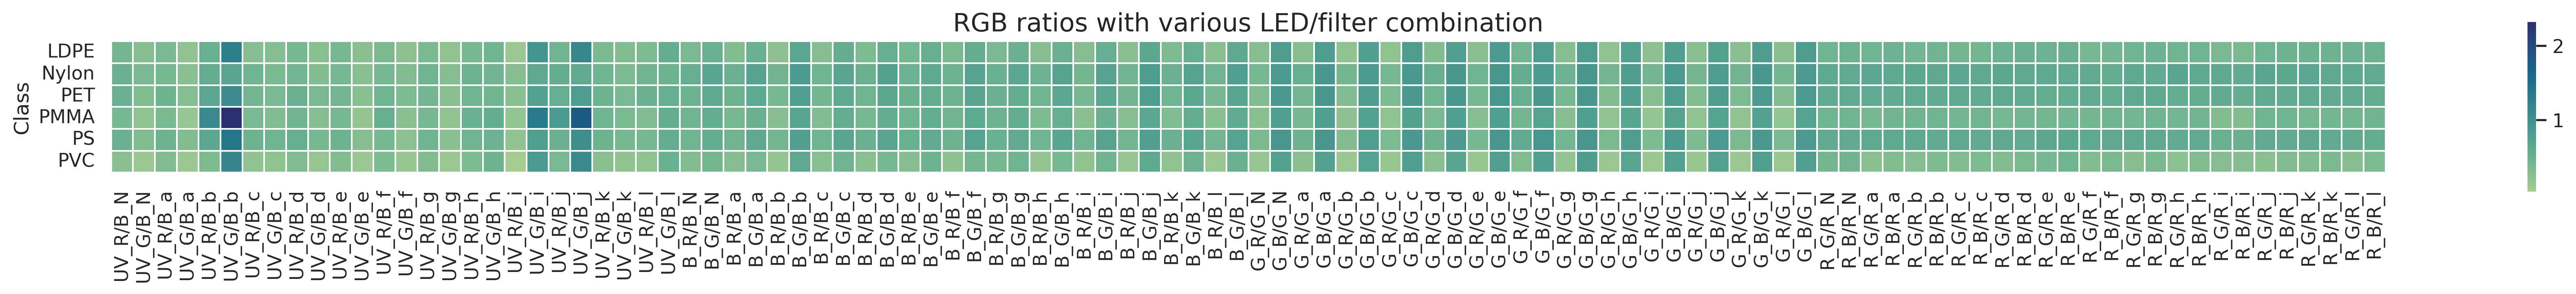

In [ ]:
df = DataML.copy()
RatioList = df.columns[df.columns.str.contains('/')]
title = 'RGB ratios with various LED/filter combination'

df2 = df.pivot_table(df, index=['Class'], aggfunc={i: np.mean for i in RatioList})
df2 = df2[sort_ratio(RatioList)]
display(df2)

# Plot the mean as heatmap
# x-axis: filter combo; y-axis: class
sns.set_theme(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 9), dpi=300) #figsize = (30, 9) for all filter; 11,9

# Draw the heatmap with the mask and correct aspect ratio
#sns.heatmap(df2, annot=True, fmt=".1f", cmap="crest", vmin=0 , vmax=3.5, square=True, linewidth=.5, cbar_kws={"shrink": .4})
sns.heatmap(df2, annot=False, cmap="crest", square=True, linewidth=.5, cbar_kws={"shrink": 0.2})
ax.set_title(title, fontsize = 15)
#ax.set_xlabel('RGB ratios with various LED/filter combination', fontsize = 12)
plt.show()
#fignum+=1
#title = str(fignum)+".png"
#plt.savefig(title, transparent=True, bbox_inches='tight')

In [ ]:
df2.to_csv('/content/drive/MyDrive/Yisha/MNP/Aero-37-75.csv')

##Ver1 - random shuffle
Each block has been treated as individual/irrelevant sample in random splitting of test and train, which means two blocks from one sets of pictures of one view could be in test and train.

**Cross Validation**

It gives scores of cross-validation and a heatmap showing predition results of each class.

,Class,B_G/B_N,B_G/B_a,B_G/B_b,B_G/B_c,B_G/B_d,B_G/B_e,B_G/B_f,B_G/B_g,B_G/B_h,...,UV_R/B_c,UV_R/B_d,UV_R/B_e,UV_R/B_f,UV_R/B_g,UV_R/B_h,UV_R/B_i,UV_R/B_j,UV_R/B_k,UV_R/B_l
0,LDPE,0.893878,0.816974,0.879121,0.859969,0.832722,0.959184,0.697143,0.917882,0.707346,...,0.636177,0.757188,0.588868,0.726538,0.973266,0.744494,0.227599,0.906671,0.889618,0.639735
1,LDPE,0.881634,0.756252,0.864548,0.844592,0.783953,0.945387,0.665660,0.894386,0.625059,...,0.559913,0.664175,0.498242,0.671271,0.967293,0.697553,0.294624,0.910601,0.858308,0.597750
2,LDPE,0.882386,0.781115,0.849776,0.844204,0.792428,0.936845,0.666242,0.896771,0.659425,...,0.556353,0.671878,0.515532,0.659970,0.970391,0.698901,0.328944,0.906892,0.855249,0.607161
3,LDPE,0.902918,0.806157,0.887596,0.869551,0.825563,0.949582,0.686723,0.911448,0.682662,...,0.621455,0.724063,0.573873,0.708429,0.968124,0.735190,0.245295,0.896825,0.876360,0.633544
4,LDPE,0.873476,0.771793,0.877131,0.840744,0.795637,0.941158,0.669157,0.893436,0.671442,...,0.578544,0.683339,0.523687,0.664388,0.969803,0.710681,0.284499,0.902352,0.861558,0.611084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,PVC,0.769943,0.707957,0.827735,0.818157,0.786576,0.812022,0.609444,0.820777,0.687710,...,0.612044,0.568440,0.633512,0.671594,0.805130,0.702026,0.140481,0.723493,0.792584,0.679104
644,PVC,0.783706,0.712214,0.836386,0.811631,0.810184,0.822046,0.588095,0.827258,0.701608,...,0.595960,0.582162,0.695041,0.682820,0.798761,0.696438,0.034221,0.704104,0.787432,0.607505
645,PVC,0.789951,0.710508,0.825324,0.808497,0.826922,0.821520,0.602590,0.820208,0.665611,...,0.586127,0.595506,0.575097,0.684143,0.797701,0.689473,0.188658,0.715396,0.825166,0.733360
646,PVC,0.773191,0.709278,0.833915,0.818257,0.824385,0.821785,0.572180,0.818735,0.691972,...,0.601134,0.592121,0.632915,0.692117,0.802651,0.695059,0.136819,0.714464,0.783334,0.716436


Classes are:  ['LDPE', 'Nylon', 'PET', 'PMMA', 'PS', 'PVC']
The classifier is <class 'xgboost.sklearn.XGBClassifier'>
Cross validation scores are: [0.96703297 0.98901099 0.98901099 0.98888889 0.98888889]
In average: 0.9846 accuracy with a standard deviation of 0.01


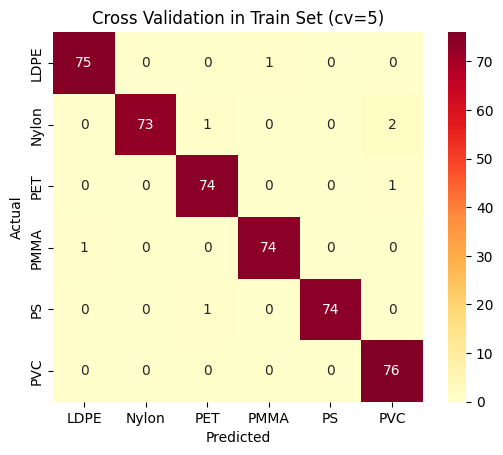

<Figure size 3300x2700 with 0 Axes>

In [40]:
import sklearn
import xgboost as xgb

'''Select dataset for train and test'''
#dataFrame = DataML_Nofilter
dataFrame = DataML
#if you want to use the dataset disregaring zero-particle
#dataFrame = DataML_Nofilter.loc[(DataML_Nofilter!=0).all(axis=1)]
#dataFrame = DataML.loc[(DataML!=0).all(axis=1)]

dataFrame = dataFrame.drop(columns=['View'])
display(dataFrame)
#dataFrame = df_merge_NameReplaced

#Extract info from dataframe
#y is class
#x is an array of values in features
y = dataFrame['Class']
X = dataFrame.drop(["Class"], axis=1)
#X = X.values

'''
#Find class contents
from sklearn.utils.multiclass import unique_labels
unique_labels(y)
labels = unique_labels(y)
'''

#Preprocessing the classes info from string to number: encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
labels = list(le.classes_)
print("Classes are: ", labels)


#Shuffle-Split dataset into train and test
from sklearn.model_selection import train_test_split
test_size = 0.3
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                    random_state=random_state,
                                                    stratify=y) #Default shuffle=True


#Use XGBoost as classifier
xgb_cl = xgb.XGBClassifier()
print('The classifier is', type(xgb_cl))

from sklearn.model_selection import cross_val_score
cv=5
scores=cross_val_score(estimator=xgb_cl,X=X_train,y=y_train,cv=cv) #cv: -folds of cross-validation, <=repeat number
#scores=cross_val_score(estimator=xgb_cl,X=X,y=y,cv=cv) #all data
print("Cross validation scores are:", scores)
print("In average: %0.4f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

pred = cross_val_predict(xgb_cl, X_train, y_train, cv=5)
#pred = cross_val_predict(xgb_cl1, X, y, cv=5) #all data
cm1 = confusion_matrix(y_train, pred)

ax = sns.heatmap(cm1, annot=True, cmap="YlOrRd", square='True')
ax.set_title(f'Cross Validation in Train Set (cv={cv})');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in the same order as above (alphabetical order if resorted automatically)
ax.yaxis.set_ticklabels(labels, fontsize="10")
ax.xaxis.set_ticklabels(labels, fontsize="10")
plt.figure(figsize=(11, 9), dpi=300)

## Display the visualization of the Confusion Matrix.
plt.show()
#plt.savefig('1.png', transparent=True, bbox_inches='tight')


**Accuracy on split test data**

array([0, 0, 1, 1, 0, 2, 4, 2, 1, 3, 5, 4, 5, 4, 0, 3, 0, 5, 3, 3, 4, 2,
       5, 5, 2, 2, 2, 5, 0, 4, 0, 4, 5, 5, 5, 0, 1, 4, 5, 5, 2, 5, 3, 3,
       5, 2, 1, 3, 5, 4, 5, 5, 0, 1, 2, 3, 2, 5, 4, 1, 4, 1, 5, 0, 3, 0,
       4, 5, 0, 2, 0, 3, 4, 4, 2, 5, 1, 0, 0, 4, 0, 5, 1, 2, 3, 0, 0, 1,
       2, 1, 3, 2, 0, 4, 3, 3, 1, 3, 4, 2, 0, 4, 2, 2, 3, 3, 1, 0, 5, 0,
       5, 4, 4, 1, 1, 2, 2, 1, 2, 4, 0, 5, 4, 3, 3, 1, 5, 3, 0, 2, 3, 5,
       2, 5, 0, 4, 1, 3, 4, 4, 1, 5, 1, 1, 4, 1, 3, 5, 4, 3, 5, 0, 4, 5,
       1, 1, 0, 1, 4, 3, 0, 2, 3, 3, 2, 1, 3, 4, 2, 3, 2, 5, 3, 5, 4, 4,
       3, 1, 2, 1, 0, 4, 1, 3, 2, 0, 4, 2, 0, 1, 0, 1, 5, 3, 2])

array([0, 0, 1, 1, 0, 2, 4, 2, 1, 3, 5, 4, 5, 4, 0, 3, 0, 5, 3, 3, 4, 2,
       5, 5, 2, 2, 2, 5, 0, 4, 0, 4, 5, 5, 5, 0, 1, 4, 5, 5, 2, 5, 3, 3,
       5, 2, 1, 3, 5, 4, 5, 5, 0, 1, 2, 3, 2, 5, 4, 1, 4, 2, 1, 0, 3, 0,
       4, 5, 0, 2, 0, 3, 4, 4, 2, 5, 2, 0, 0, 4, 0, 5, 1, 2, 3, 0, 0, 1,
       2, 1, 3, 2, 0, 4, 3, 3, 1, 3, 4, 2, 0, 4, 2, 2, 3, 3, 2, 0, 5, 0,
       5, 4, 4, 1, 1, 2, 2, 1, 2, 4, 0, 1, 4, 3, 3, 1, 5, 3, 0, 2, 3, 5,
       2, 5, 0, 4, 1, 3, 4, 4, 1, 5, 1, 1, 4, 1, 3, 5, 4, 3, 5, 0, 4, 5,
       1, 1, 0, 1, 4, 3, 0, 2, 3, 3, 2, 1, 3, 4, 2, 3, 1, 5, 3, 5, 4, 4,
       3, 1, 2, 1, 0, 4, 1, 3, 2, 0, 4, 2, 0, 1, 0, 1, 5, 3, 2])

The shuffle-splitted test set size is 30.00%
The prediction accuracy on test data is 96.92%


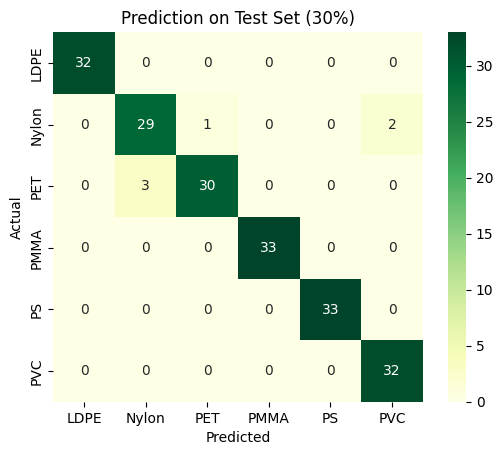

<Figure size 3300x2700 with 0 Axes>

In [39]:
from sklearn.metrics import accuracy_score
#init classifier
#xgb_cl = xgb.XGBClassifier()

#Fit
xgb_cl.fit(X_train, y_train)

#Predic
y_predict=xgb_cl.predict(X_test)
display(y_predict)
display(y_test)

#Score
print('The shuffle-splitted test set size is {:.2%}'.format(test_size))
print('The prediction accuracy on test data is {:.2%}'.format(accuracy_score(y_test,y_predict)))

#Draw a heatmap
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm1 = confusion_matrix(y_test, y_predict)

ax = sns.heatmap(cm1, annot=True, cmap="YlGn", square='True')
ax.set_title('Prediction on Test Set ({:.0%})'.format(test_size));
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in the same order as above (alphabetical order if resorted automatically)
ax.yaxis.set_ticklabels(labels, fontsize="10")
ax.xaxis.set_ticklabels(labels, fontsize="10")
plt.figure(figsize=(11, 9), dpi=300)

## Display the visualization of the Confusion Matrix.
plt.show()
#plt.savefig('1.png', transparent=True, bbox_inches='tight')

##Ver2 - split views into test data
One block is still one sample in dataset. But blocks from one view will not be splited, and enter test and train sets at the same time.

In [32]:
import sklearn
import xgboost as xgb
import random

def TestTrainSplit_View(dataFrame, ViewNum =12, test_size = 3, RandomSeed = 42):
  TestData = pd.DataFrame()
  TrainData = pd.DataFrame()
  for label in labels:
    dataonelabel = dataFrame[dataFrame['Class']==label]
    RandomSeed += 1
    random.seed(a=RandomSeed, version=2)
    RandomList = random.sample(range(1, ViewNum+1), test_size)
    df = (dataonelabel.loc[~dataonelabel['View'].isin(RandomList)]
                .drop(columns='View'))
    TrainData = pd.concat([TrainData, df], ignore_index=True)
    df = (dataonelabel.loc[dataonelabel['View'].isin(RandomList)]
                .drop(columns='View'))
    TestData = pd.concat([TestData, df], ignore_index=True)
  return TrainData, TestData


'''Select dataset for train and test'''
#dataFrame = DataML_Nofilter
dataFrame = DataML
#if you want to use the dataset disregaring zero-particle
#dataFrame = DataML_Nofilter.loc[(DataML_Nofilter!=0).all(axis=1)]
#dataFrame = DataML.loc[(DataML!=0).all(axis=1)]

#Find class contents
from sklearn.utils.multiclass import unique_labels
labels = unique_labels(dataFrame['Class'])

'''
#Shuffle-Split dataset into train and test
from sklearn.model_selection import train_test_split
test_size = 0.3
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                    random_state=random_state,
                                                    stratify=y) #Default shuffle=True
'''

#RandomSeed=6 #optimized for spray <37µm+zeros no clay
RandomSeed = 6
ViewNum = 12 #number of views
test_size = 3 #number of views be tested
TrainData, TestData = TestTrainSplit_View(dataFrame, ViewNum, test_size, RandomSeed)
#display(TrainData)
#display(TestData)


#Extract info from dataframe
#y is class
#x is an array of values in features
y_train = TrainData['Class']
X_train = TrainData.drop(['Class'], axis=1)
RatioList = X_train.columns
X_train = X_train[sort_ratio(RatioList)]
print('train dataset')
print(list(y_train))
display(X_train)

y_test = TestData['Class']
X_test = TestData.drop(['Class'], axis=1)
X_test = X_test[sort_ratio(RatioList)]
print('test dataset')
print(list(y_test))
display(X_test)


#Preprocessing the classes info from string to number: encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
labels = list(le.classes_)
print("Classes are: ", labels)

train dataset
['LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nyl

,UV_R/B_N,UV_G/B_N,UV_R/B_a,UV_G/B_a,UV_R/B_b,UV_G/B_b,UV_R/B_c,UV_G/B_c,UV_R/B_d,UV_G/B_d,...,R_G/R_h,R_B/R_h,R_G/R_i,R_B/R_i,R_G/R_j,R_B/R_j,R_G/R_k,R_B/R_k,R_G/R_l,R_B/R_l
0,0.915565,0.509515,0.737272,0.143263,1.099723,1.272792,0.636177,0.245051,0.757188,0.251540,...,0.506419,0.526895,0.469436,0.437913,0.590413,0.602239,0.470858,0.532531,0.613850,0.560637
1,0.901369,0.424605,0.653950,0.077869,1.081289,1.260112,0.559913,0.184888,0.664175,0.159742,...,0.432614,0.493509,0.465975,0.435990,0.551949,0.589658,0.434043,0.507747,0.531297,0.546886
2,0.908585,0.470607,0.647525,0.093095,1.074787,1.256876,0.556353,0.206633,0.671878,0.174132,...,0.469550,0.514749,0.485052,0.443312,0.562840,0.602300,0.451682,0.522648,0.565427,0.565111
3,0.909037,0.471640,0.707800,0.122140,1.076063,1.267276,0.621455,0.220871,0.724063,0.212564,...,0.502083,0.535975,0.486573,0.446611,0.591733,0.608797,0.481810,0.535879,0.584884,0.562547
4,0.897290,0.424801,0.659588,0.083648,1.078750,1.257862,0.578544,0.187173,0.683339,0.166495,...,0.475725,0.517651,0.496992,0.449904,0.569369,0.594193,0.460195,0.525481,0.560048,0.549970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,0.812840,0.637905,0.680419,0.332961,0.735333,1.115241,0.612044,0.457499,0.568440,0.324966,...,0.750099,0.689300,0.571075,0.549590,0.781994,0.730614,0.724999,0.676618,0.745735,0.705569
482,0.707721,0.602843,0.685239,0.330242,0.743200,1.124597,0.595960,0.460899,0.582162,0.308911,...,0.744953,0.686525,0.547901,0.534107,0.788506,0.724346,0.727668,0.665949,0.766672,0.703816
483,0.864641,0.633494,0.685288,0.320670,0.716778,1.123323,0.586127,0.440532,0.595506,0.309284,...,0.752178,0.701131,0.607043,0.561391,0.792589,0.714810,0.753447,0.693506,0.774499,0.710155
484,0.678903,0.563673,0.672031,0.348105,0.696852,1.138131,0.601134,0.466157,0.592121,0.320585,...,0.753664,0.689868,0.593745,0.545610,0.777198,0.713535,0.735578,0.686801,0.761542,0.715691


test dataset
['LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'LDPE', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'Nylon', 'PET', 'PET', 'PET', 'PET', 'PET', 'PET', 'PET', 'PET', 'PET', 'PET', 'PET', 'PET', 'PET', 'PET', 'PET', 'PET', 'PET', 'PET', 'PET', 'PET', 'PET', 'PET', 'PET', 'PET', 'PET', 'PET', 'PET', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PMMA', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'P

,UV_R/B_N,UV_G/B_N,UV_R/B_a,UV_G/B_a,UV_R/B_b,UV_G/B_b,UV_R/B_c,UV_G/B_c,UV_R/B_d,UV_G/B_d,...,R_G/R_h,R_B/R_h,R_G/R_i,R_B/R_i,R_G/R_j,R_B/R_j,R_G/R_k,R_B/R_k,R_G/R_l,R_B/R_l
0,0.890309,0.429311,0.475630,0.057781,1.127403,1.278945,0.579570,0.219437,0.429861,0.051790,...,0.350642,0.419206,0.485104,0.454077,0.648993,0.625669,0.615486,0.639938,0.387739,0.440852
1,0.878074,0.387113,0.454082,0.065044,1.112608,1.265244,0.521503,0.180962,0.380127,0.071145,...,0.328674,0.406568,0.468387,0.439700,0.624155,0.623134,0.585779,0.625976,0.365561,0.429584
2,0.904259,0.472858,0.494765,0.059766,1.107236,1.261747,0.604030,0.278981,0.468250,0.051946,...,0.370858,0.436545,0.532549,0.479798,0.684061,0.640699,0.594470,0.624528,0.393282,0.453813
3,0.883995,0.395270,0.462820,0.078930,1.077894,1.224403,0.482842,0.199125,0.376613,0.083615,...,0.350043,0.406935,0.497120,0.450248,0.658448,0.635801,0.565219,0.604756,0.381045,0.434681
4,0.896485,0.432612,0.474076,0.062918,1.068805,1.224563,0.545425,0.243930,0.441925,0.055007,...,0.331190,0.418393,0.542499,0.480698,0.710300,0.662944,0.550358,0.603529,0.361233,0.433488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.583121,0.249881,0.543296,0.144504,0.838470,1.143392,0.581474,0.344271,0.580719,0.249799,...,0.498493,0.552094,0.564498,0.538787,0.669870,0.627002,0.540369,0.572211,0.578391,0.594730
158,0.613771,0.250887,0.524913,0.144652,0.844784,1.122845,0.586681,0.335876,0.556168,0.231559,...,0.466196,0.531683,0.545639,0.522698,0.655768,0.618961,0.514047,0.548367,0.553190,0.580697
159,0.563813,0.242592,0.556832,0.149286,0.803265,1.144814,0.574056,0.332973,0.595176,0.254836,...,0.463243,0.541238,0.562236,0.533728,0.673156,0.628389,0.526074,0.558478,0.560457,0.588294
160,0.585309,0.234456,0.522615,0.125598,0.824770,1.131760,0.559321,0.307714,0.563959,0.230073,...,0.441262,0.531265,0.528792,0.518946,0.636754,0.613246,0.486382,0.534066,0.508455,0.569086


Classes are:  ['LDPE', 'Nylon', 'PET', 'PMMA', 'PS', 'PVC']


### A try from https://shap.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html

In [ ]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [ ]:
import xgboost
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgboost.train(params, xgb_train, 5000, evals = [(xgb_test, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:4.19193
[1000]	test-cox-nloglik:3.99224
[2000]	test-cox-nloglik:3.99260
[3000]	test-cox-nloglik:4.03566
[4000]	test-cox-nloglik:4.10535
[4999]	test-cox-nloglik:4.18380


In [ ]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

# see how well we can order people by survival
c_statistic_harrell(model_train.predict(xgb_test), y_test)

0.8296929408040519

In [ ]:
model_train.predict(xgb_test)

array([1.03005347e+03, 1.75311011e+03, 1.24955017e+03, 1.53400403e+03,
       1.55095007e+03, 1.36267773e+03, 1.39663733e+03, 2.13488232e+03,
       9.95588623e+02, 3.77397363e+03, 5.08381543e+03, 2.27667554e+03,
       2.25215894e+03, 5.64962354e+03, 2.59348755e+03, 2.72006494e+03,
       2.28061230e+04, 3.41394214e+03, 6.35658188e+05, 1.26759550e+06,
       5.78290062e+05, 1.02489356e+06, 9.27655375e+05, 5.26254938e+05,
       3.03778750e+05, 5.16081656e+05, 8.74068438e+05, 5.26953242e+04,
       5.18570898e+04, 1.60389438e+05, 6.55246289e+04, 8.96500781e+04,
       2.94639609e+04, 7.30371016e+04, 6.33143438e+04, 1.62258859e+05,
       7.64016172e+04, 4.12979297e+04, 8.23147031e+04, 5.75543203e+04,
       4.20239570e+04, 4.43758594e+04, 4.01655438e+05, 3.80166219e+05,
       8.35248203e+04, 1.13650523e+05, 1.06882047e+05, 5.88623477e+04,
       1.09741164e+05, 8.73607969e+04, 2.24180566e+04, 3.46014594e+05,
       1.17110664e+05, 1.15271281e+05, 5.39603945e+04, 9.21881797e+04,
      

ValueError: The number of FixedLocator locations (22), usually from a call to set_ticks, does not match the number of labels (6).

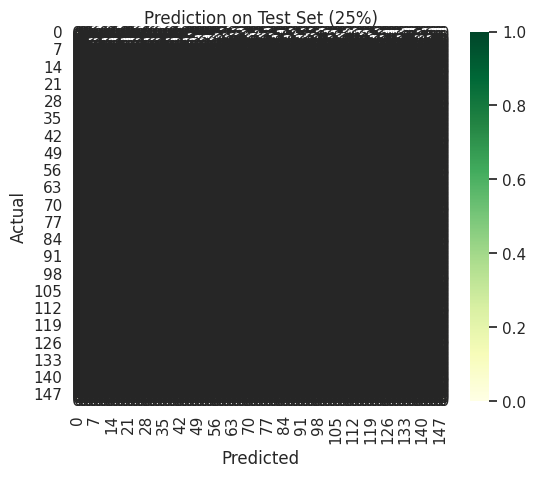

In [ ]:
cm1 = confusion_matrix(y_test, model_train.predict(xgb_test))

ax = sns.heatmap(cm1, annot=True, cmap="YlGn", square='True')
ax.set_title('Prediction on Test Set ({:.0%})'.format(test_size/ViewNum));
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in the same order as above (alphabetical order if resorted automatically)
ax.yaxis.set_ticklabels(labels, fontsize="10")
ax.xaxis.set_ticklabels(labels, fontsize="10")
plt.figure(figsize=(11, 9), dpi=300)

## Display the visualization of the Confusion Matrix.
plt.show()

### Cross-validation within the training dataset
- default params

The classifier is <class 'xgboost.sklearn.XGBClassifier'>
Cross validation scores are: [0.80612245 0.87628866 0.93814433 0.90721649 0.83505155]
In average: 0.8726 accuracy with a standard deviation of 0.05


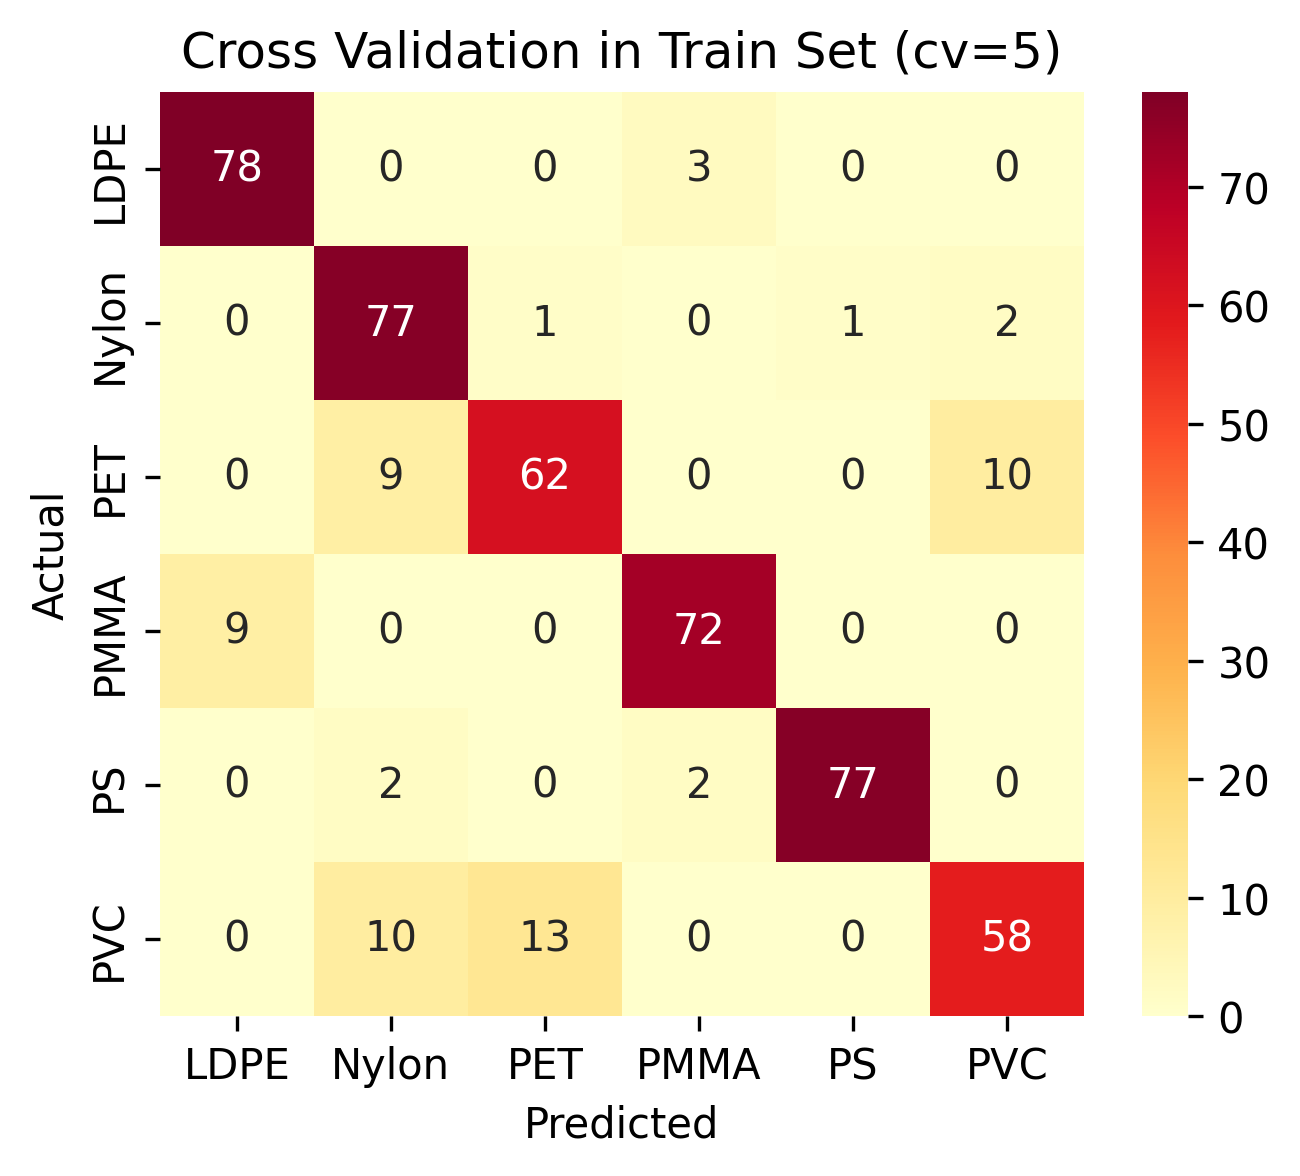

In [33]:
cv=5
#Use XGBoost as classifier
xgb_cl = xgb.XGBClassifier()
print('The classifier is', type(xgb_cl))

from sklearn.model_selection import cross_val_score
scores=cross_val_score(estimator=xgb_cl,X=X_train,y=y_train,cv=cv) #cv: -folds of cross-validation, <=repeat number
#scores=cross_val_score(estimator=xgb_cl,X=X,y=y,cv=cv) #all data
print("Cross validation scores are:", scores)
print("In average: %0.4f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

pred = cross_val_predict(xgb_cl, X_train, y_train, cv=cv)
cm = confusion_matrix(y_train, pred)
#cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(5, 4), dpi=300)

ax = sns.heatmap(cm, annot=True, cmap="YlOrRd", square='True')
ax.set_title(f'Cross Validation in Train Set (cv={cv})')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in the same order as above (alphabetical order if resorted automatically)
ax.yaxis.set_ticklabels(labels, fontsize="10")
ax.xaxis.set_ticklabels(labels, fontsize="10")


## Display the visualization of the Confusion Matrix.
plt.show()
#plt.savefig('1.png', transparent=True, bbox_inches='tight')

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 5, 2, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 5, 5, 5, 2, 1, 5, 2, 2, 5, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 2, 5,
       5, 5, 5, 5, 5, 5, 5, 5])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5])

The random-splitted test set size is 3 out of 12 Views
The prediction accuracy on test data is 82.72%


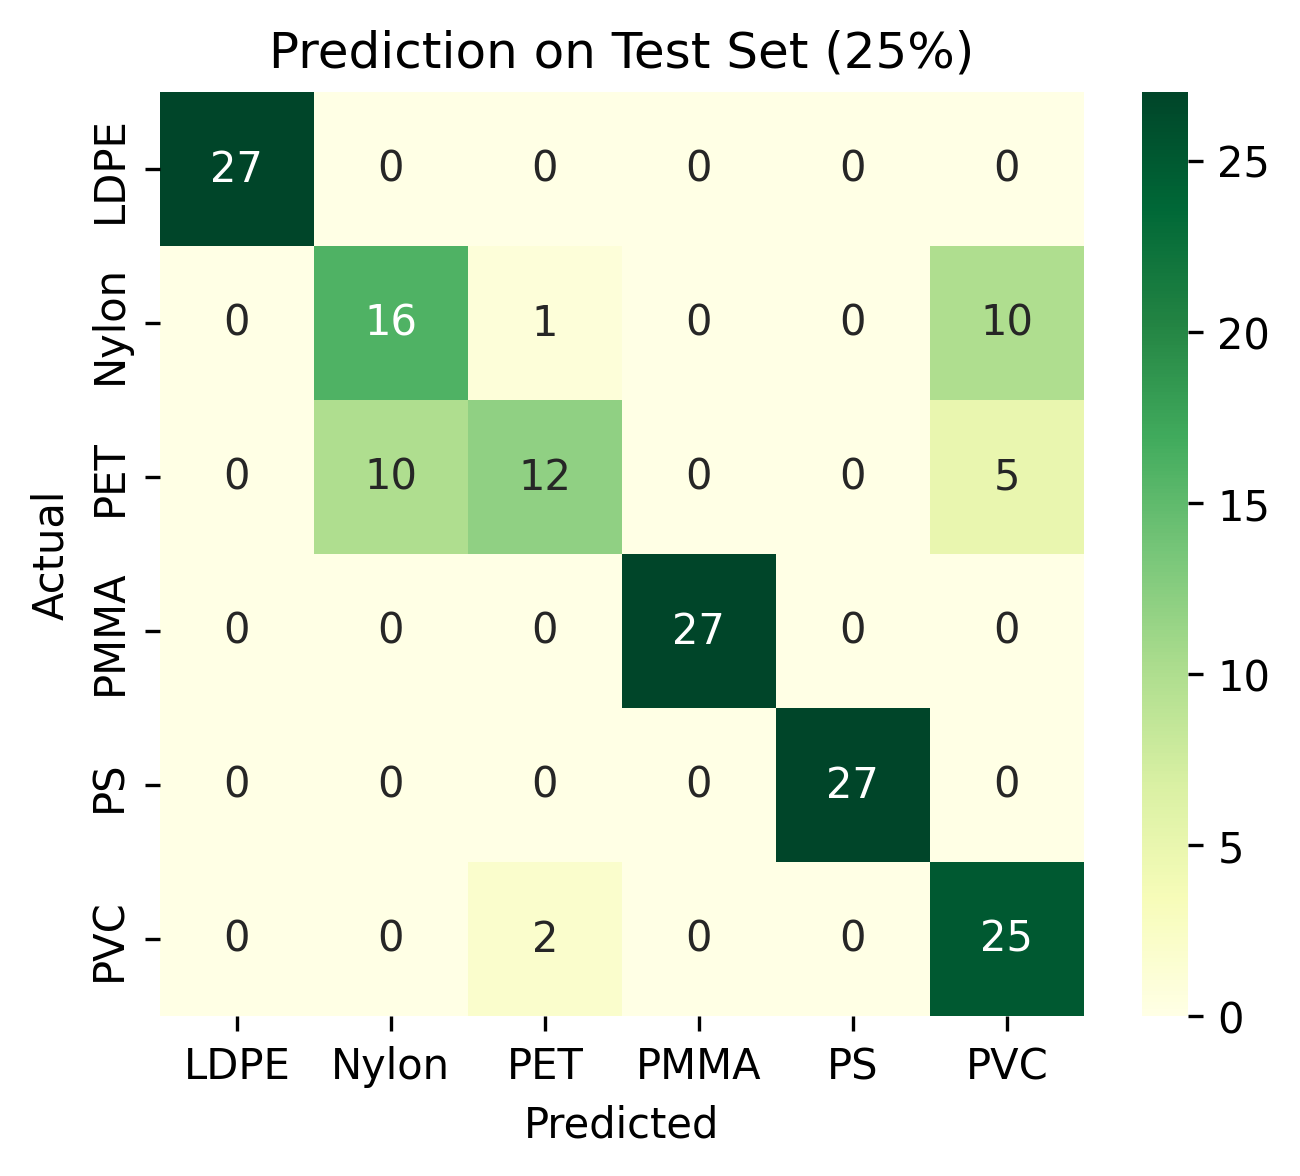

In [34]:
from sklearn.metrics import accuracy_score
#init classifier
#xgb_cl = xgb.XGBClassifier()

#Fit
xgb_cl.fit(X_train, y_train)

#Predic
y_predict=xgb_cl.predict(X_test)
display(y_predict)
display(y_test)

#Score
print('The random-splitted test set size is', test_size, 'out of', ViewNum, 'Views')
print('The prediction accuracy on test data is {:.2%}'.format(accuracy_score(y_test,y_predict)))

#Draw a heatmap
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm1 = confusion_matrix(y_test, y_predict)

plt.figure(figsize=(5,4), dpi=300)
ax = sns.heatmap(cm1, annot=True, cmap="YlGn", square='True')
ax.set_title('Prediction on Test Set ({:.0%})'.format(test_size/ViewNum));
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in the same order as above (alphabetical order if resorted automatically)
ax.yaxis.set_ticklabels(labels, fontsize="10")
ax.xaxis.set_ticklabels(labels, fontsize="10")


## Display the visualization of the Confusion Matrix.
plt.show()
#plt.savefig('1.png', transparent=True, bbox_inches='tight')

<Axes: >

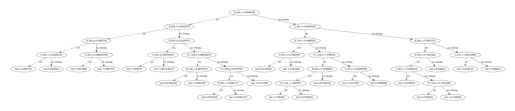

In [ ]:
from xgboost import plot_tree
plot_tree(xgb_cl)

### Random seed--> accuracy.

,Class,View,B_G/B_N,B_G/B_a,B_G/B_b,B_G/B_c,B_G/B_d,B_G/B_e,B_G/B_f,B_G/B_g,...,UV_R/B_c,UV_R/B_d,UV_R/B_e,UV_R/B_f,UV_R/B_g,UV_R/B_h,UV_R/B_i,UV_R/B_j,UV_R/B_k,UV_R/B_l
0,LDPE,1,0.893878,0.816974,0.879121,0.859969,0.832722,0.959184,0.697143,0.917882,...,0.636177,0.757188,0.588868,0.726538,0.973266,0.744494,0.227599,0.906671,0.889618,0.639735
1,LDPE,1,0.881634,0.756252,0.864548,0.844592,0.783953,0.945387,0.665660,0.894386,...,0.559913,0.664175,0.498242,0.671271,0.967293,0.697553,0.294624,0.910601,0.858308,0.597750
2,LDPE,1,0.882386,0.781115,0.849776,0.844204,0.792428,0.936845,0.666242,0.896771,...,0.556353,0.671878,0.515532,0.659970,0.970391,0.698901,0.328944,0.906892,0.855249,0.607161
3,LDPE,1,0.902918,0.806157,0.887596,0.869551,0.825563,0.949582,0.686723,0.911448,...,0.621455,0.724063,0.573873,0.708429,0.968124,0.735190,0.245295,0.896825,0.876360,0.633544
4,LDPE,1,0.873476,0.771793,0.877131,0.840744,0.795637,0.941158,0.669157,0.893436,...,0.578544,0.683339,0.523687,0.664388,0.969803,0.710681,0.284499,0.902352,0.861558,0.611084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,PVC,12,0.769943,0.707957,0.827735,0.818157,0.786576,0.812022,0.609444,0.820777,...,0.612044,0.568440,0.633512,0.671594,0.805130,0.702026,0.140481,0.723493,0.792584,0.679104
644,PVC,12,0.783706,0.712214,0.836386,0.811631,0.810184,0.822046,0.588095,0.827258,...,0.595960,0.582162,0.695041,0.682820,0.798761,0.696438,0.034221,0.704104,0.787432,0.607505
645,PVC,12,0.789951,0.710508,0.825324,0.808497,0.826922,0.821520,0.602590,0.820208,...,0.586127,0.595506,0.575097,0.684143,0.797701,0.689473,0.188658,0.715396,0.825166,0.733360
646,PVC,12,0.773191,0.709278,0.833915,0.818257,0.824385,0.821785,0.572180,0.818735,...,0.601134,0.592121,0.632915,0.692117,0.802651,0.695059,0.136819,0.714464,0.783334,0.716436


RandomSeed = 6
The prediction accuracy on test data is 76.47%
RandomSeed = 7
The prediction accuracy on test data is 70.59%
RandomSeed = 8
The prediction accuracy on test data is 83.95%
RandomSeed = 9
The prediction accuracy on test data is 79.01%
RandomSeed = 10
The prediction accuracy on test data is 80.39%
RandomSeed = 11
The prediction accuracy on test data is 87.58%
RandomSeed = 12
The prediction accuracy on test data is 83.66%
RandomSeed = 13
The prediction accuracy on test data is 69.93%
RandomSeed = 14
The prediction accuracy on test data is 79.74%
RandomSeed = 15
The prediction accuracy on test data is 78.47%
RandomSeed = 16
The prediction accuracy on test data is 88.24%
RandomSeed = 17
The prediction accuracy on test data is 80.39%
RandomSeed = 18
The prediction accuracy on test data is 79.08%
RandomSeed = 19
The prediction accuracy on test data is 88.19%
RandomSeed = 20
The prediction accuracy on test data is 75.69%
RandomSeed = 21
The prediction accuracy on test data is 80.

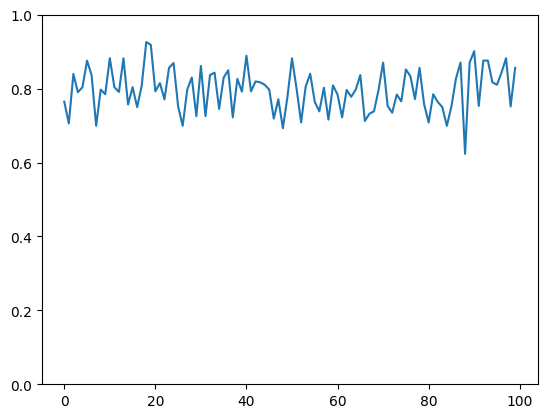

In [ ]:
import sklearn
import xgboost as xgb
import random
from sklearn.metrics import accuracy_score

def ViewSplitXGBoostAccuracy(RandomSeed, dataFrame):
  ViewNum = 12 #number of views
  test_size = 3 #number of views be tested
  TestData = pd.DataFrame()
  TrainData = pd.DataFrame()

  from sklearn.utils.multiclass import unique_labels
  labels = unique_labels(dataFrame['Class'])

  for label in labels:
    dataonelabel = dataFrame[dataFrame['Class']==label]
    RandomSeed += 1
    random.seed(a=RandomSeed, version=2)
    RandomList = random.sample(range(ViewNum), test_size)
    df = (dataonelabel.loc[~dataonelabel['View'].isin(RandomList)]
                .drop(columns='View'))
    TrainData = pd.concat([TrainData, df], ignore_index=True)
    df = (dataonelabel.loc[dataonelabel['View'].isin(RandomList)]
                .drop(columns='View'))
    TestData = pd.concat([TestData, df], ignore_index=True)

  #Extract info from dataframe
  #y is class
  #x is an array of values in features
  y_train = TrainData['Class']
  X_train = TrainData.drop(['Class'], axis=1)
  y_test = TestData['Class']
  X_test = TestData.drop(['Class'], axis=1)

  #Preprocessing the classes info from string to number: encoding
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  y_train = le.fit_transform(y_train)
  y_test = le.fit_transform(y_test)

  #Use XGBoost as classifier
  xgb_cl = xgb.XGBClassifier()

  #Fit
  xgb_cl.fit(X_train, y_train)

  #Predic
  y_predict=xgb_cl.predict(X_test)
  accuracy = accuracy_score(y_test,y_predict)
  #Score
  print('RandomSeed =', RandomSeed)
  print('The prediction accuracy on test data is {:.2%}'.format(accuracy))
  return accuracy


dataFrame = DataML
display(dataFrame)
Accuracy = [ViewSplitXGBoostAccuracy(RandomSeed, dataFrame) for RandomSeed in range(100)]
plt.ylim(0,1)
plt.plot(Accuracy)
from statistics import mean
print(mean(Accuracy))

In [ ]:
dataFrame = DataML
Accuracy = [ViewSplitXGBoostAccuracy(RandomSeed, dataFrame) for RandomSeed in range(100)]

The prediction accuracy on test data is 76.71%
The prediction accuracy on test data is 66.43%
The prediction accuracy on test data is 77.27%
The prediction accuracy on test data is 66.67%
The prediction accuracy on test data is 85.42%
The prediction accuracy on test data is 79.73%
The prediction accuracy on test data is 80.82%
The prediction accuracy on test data is 80.26%
The prediction accuracy on test data is 76.39%
The prediction accuracy on test data is 72.79%
The prediction accuracy on test data is 69.86%
The prediction accuracy on test data is 73.29%
The prediction accuracy on test data is 80.26%
The prediction accuracy on test data is 94.78%
The prediction accuracy on test data is 78.72%
The prediction accuracy on test data is 74.83%
The prediction accuracy on test data is 91.30%
The prediction accuracy on test data is 59.06%
The prediction accuracy on test data is 73.64%
The prediction accuracy on test data is 77.60%
The prediction accuracy on test data is 84.62%
The predictio

0.7636199446332403


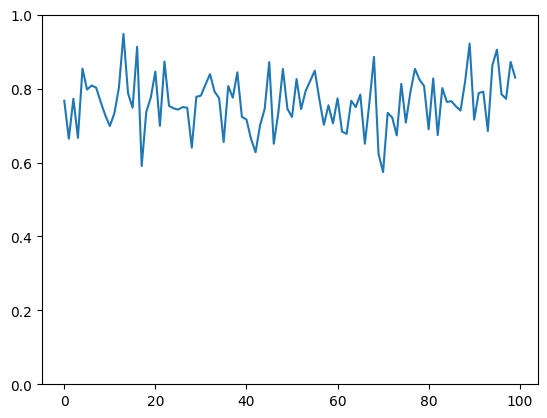

In [ ]:
plt.ylim(0,1)
plt.plot(Accuracy)
from statistics import mean
print(mean(Accuracy))

##Feature Selection

[8.9984015e-03 3.1677503e-02 1.6899459e-02 1.8563854e-02 4.0162113e-02
 4.5905348e-02 0.0000000e+00 5.8331643e-03 5.2884235e-03 2.1942721e-03
 8.7878712e-02 0.0000000e+00 0.0000000e+00 2.6694490e-04 1.6279850e-02
 4.7568535e-04 4.9654571e-03 2.4439901e-02 2.9380168e-04 5.8622700e-03
 5.6626800e-02 6.5072834e-02 1.9828365e-04 1.2058993e-03 2.3475718e-02
 4.3615256e-04 2.7644586e-02 3.7689382e-04 7.5214314e-03 3.8564578e-03
 0.0000000e+00 5.1986729e-03 1.4935839e-03 8.8742897e-03 8.1526032e-03
 1.2318171e-02 6.8478682e-03 1.5457424e-02 1.7881730e-04 2.7269451e-03
 6.2510413e-03 1.8571375e-02 0.0000000e+00 1.0484362e-03 0.0000000e+00
 6.9636558e-03 0.0000000e+00 2.1973559e-04 6.2106428e-04 1.1151328e-03
 1.0378475e-02 1.4854185e-03 4.0936258e-05 5.4137327e-04 8.3192438e-03
 0.0000000e+00 0.0000000e+00 7.6803094e-04 0.0000000e+00 3.5332695e-02
 1.2419287e-04 0.0000000e+00 0.0000000e+00 4.2340096e-02 3.3301773e-04
 0.0000000e+00 0.0000000e+00 1.3821131e-03 3.2617778e-03 1.7832196e-03
 4.160

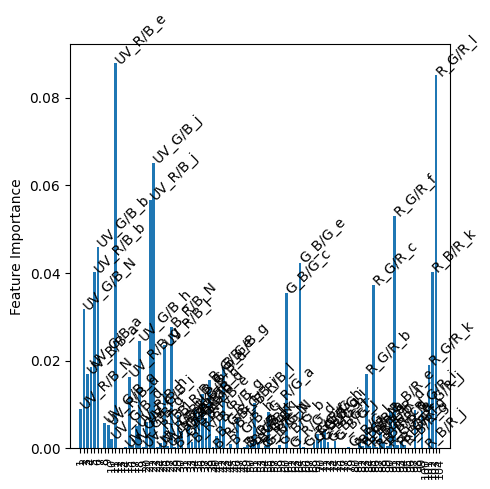

In [ ]:
# feature importance
print(xgb_cl.feature_importances_)

featureNum = len(xgb_cl.feature_importances_)
bars = [x+1 for x in range(featureNum)]

# plot
plt.figure(figsize=[5,5])
plt.bar(bars, xgb_cl.feature_importances_)

plt.xticks(bars, fontsize=8, rotation=90)
# Text on the right of each bar
for i in range(featureNum):
    string=xgb_cl.feature_names_in_[i]
    if xgb_cl.feature_importances_[i]>0:
      plt.text(x=bars[i]-0.8, y=xgb_cl.feature_importances_[i], s = string, size = 10, color='black', rotation=45)
#plt.savefig('0)Fusion Variant Frequency.png', dpi=300, bbox_inches='tight')
plt.xlim(left=bars[0]-3, right=bars[-1]+3)
plt.ylabel('Feature Importance')
plt.tight_layout()
plt.show()

[1.2510240e-03 1.2246430e-02 6.1604893e-04 7.3115975e-03 5.3302821e-02
 5.7771215e-03 1.0810247e-02 1.2839427e-02 1.2362830e-03 0.0000000e+00
 1.5437901e-03 2.9369622e-02 1.8885407e-03 7.7573583e-03 1.7534470e-02
 4.3901525e-04 7.5200492e-06 3.3889485e-03 2.8458596e-03 8.6486885e-05
 7.8630093e-03 3.6531724e-03 0.0000000e+00 0.0000000e+00 2.9046326e-03
 0.0000000e+00 1.0946980e-03 7.0025986e-03 7.8340695e-04 8.3756720e-04
 2.0305284e-03 5.9196573e-02 0.0000000e+00 2.8527901e-02 2.5593613e-03
 0.0000000e+00 1.6512028e-04 0.0000000e+00 3.6267316e-04 6.7174394e-04
 0.0000000e+00 0.0000000e+00 7.6429611e-03 9.6077909e-04 0.0000000e+00
 6.6305156e-04 0.0000000e+00 0.0000000e+00 1.8227646e-02 1.2081026e-02
 2.4295857e-03 0.0000000e+00 2.2208692e-04 2.3792107e-03 5.3058746e-03
 3.7311760e-03 2.1219416e-02 4.4002302e-02 1.7073877e-03 5.9945066e-04
 4.8245592e-03 0.0000000e+00 5.8422824e-03 6.3665430e-03 0.0000000e+00
 8.4597081e-02 1.0445832e-03 7.8641521e-03 2.7163915e-02 0.0000000e+00
 9.949

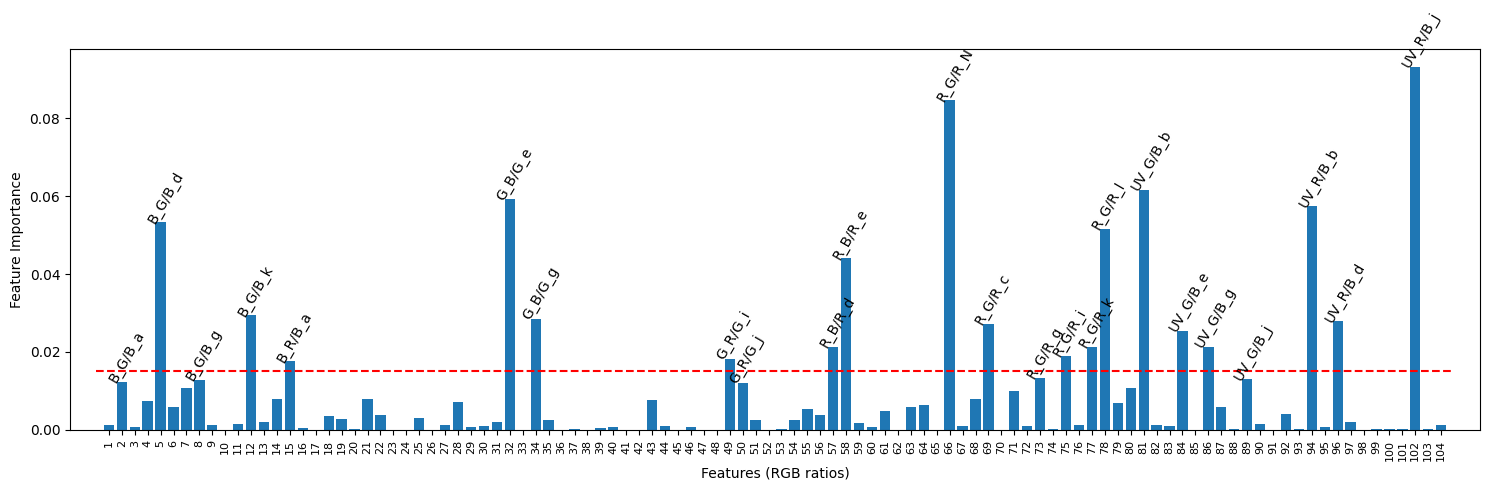

In [41]:
# with filter 104 params
# feature importance figure
xgb_cl.fit(X_train, y_train)
print(xgb_cl.feature_importances_)

featureNum = len(xgb_cl.feature_importances_)
bars = [x+1 for x in range(featureNum)]

# plot
plt.figure(figsize=[15,5])
plt.bar(bars, xgb_cl.feature_importances_)

plt.xticks(bars, fontsize=8, rotation=90)
# Text on the right of each bar
for i in range(featureNum):
    string=xgb_cl.feature_names_in_[i]
    if xgb_cl.feature_importances_[i]>0.012: plt.text(x=bars[i]-1.2, y=xgb_cl.feature_importances_[i], s = string, size = 10, color='black', rotation=60)
#plt.savefig('0)Fusion Variant Frequency.png', dpi=300, bbox_inches='tight')
plt.xlim(left=bars[0]-3, right=bars[-1]+3)
plt.ylabel('Feature Importance')
plt.xlabel('Features (RGB ratios)')
plt.hlines(y=0.015, xmin=0, xmax=105,linestyles='--', color='red')
plt.tight_layout()
plt.show()

In [37]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# fit model on all training data
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
cv_results = pd.DataFrame(columns = ['n_features', 'cv_score', 'std_cv_score', 'test accuracy' ])

# Fit model using each importance as a threshold
thresholds = np.sort(model.feature_importances_)
from sklearn.feature_selection import SelectFromModel
for thresh in thresholds:
    # select features using threshold
    selection = model.feature_names_in_[model.feature_importances_>=thresh]
    select_X_train = X_train[selection]
    select_X_test = X_test[selection]

    # Cross-validation score
    selection_model = xgb.XGBClassifier()
    scores = cross_val_score(estimator=selection_model,X=select_X_train,y=y_train,cv=cv)
    # Test accuracy
    selection_model.fit(select_X_train, y_train)
    y_predict=selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test,y_predict)
    print("Thresh=%.3f, n=%d, Cross-validation scores: %.2f%% (%.2f%%), Test accuracy: %.2f%%"
          % (thresh, len(selection), scores.mean()*100, scores.std()*100, accuracy*100))
    cv_results.loc[len(cv_results.index)]=[len(selection), scores.mean(), scores.std(), accuracy]

cv_results.to_csv('/content/drive/MyDrive/Yisha/MNP/Dry-<37_cv=5_RS=6_FeatureSelection.csv')

Thresh=0.000, n=104, Cross-validation scores: 87.26% (4.76%), Test accuracy: 82.72%
Thresh=0.000, n=104, Cross-validation scores: 87.26% (4.76%), Test accuracy: 82.72%
Thresh=0.000, n=104, Cross-validation scores: 87.26% (4.76%), Test accuracy: 82.72%
Thresh=0.000, n=104, Cross-validation scores: 87.26% (4.76%), Test accuracy: 82.72%
Thresh=0.000, n=104, Cross-validation scores: 87.26% (4.76%), Test accuracy: 82.72%
Thresh=0.000, n=104, Cross-validation scores: 87.26% (4.76%), Test accuracy: 82.72%
Thresh=0.000, n=104, Cross-validation scores: 87.26% (4.76%), Test accuracy: 82.72%
Thresh=0.000, n=104, Cross-validation scores: 87.26% (4.76%), Test accuracy: 82.72%
Thresh=0.000, n=104, Cross-validation scores: 87.26% (4.76%), Test accuracy: 82.72%
Thresh=0.000, n=104, Cross-validation scores: 87.26% (4.76%), Test accuracy: 82.72%
Thresh=0.000, n=104, Cross-validation scores: 87.26% (4.76%), Test accuracy: 82.72%
Thresh=0.000, n=104, Cross-validation scores: 87.26% (4.76%), Test accuracy:

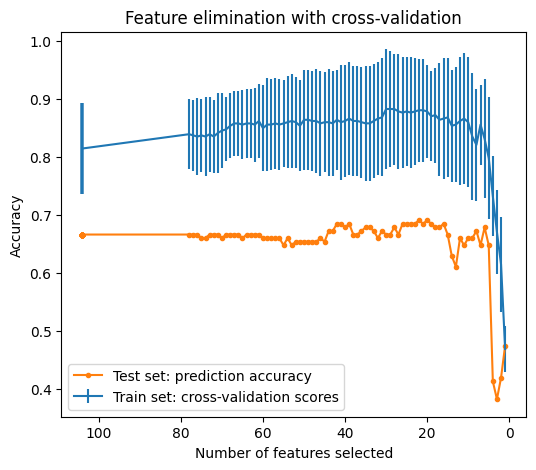

In [18]:
plt.figure(figsize=[6,5])
plt.xlabel("Number of features selected")
plt.ylabel("Accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["cv_score"],
    yerr=cv_results["std_cv_score"],
    label="Train set: cross-validation scores"
)
plt.plot(cv_results["n_features"], cv_results["test accuracy"], marker=".", label = 'Test set: prediction accuracy')
plt.title("Feature elimination with cross-validation")
plt.legend(loc = 3)
plt.gca().invert_xaxis()
plt.show()

In [22]:
cv_results[cv_results["cv_score"]==cv_results["cv_score"].max()]

,n_features,cv_score,std_cv_score,test accuracy
74,30.0,0.883105,0.103081,0.666667


##Grid Search

In [24]:
n = 30

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Fit model using each importance as a threshold
thresholds = np.sort(model.feature_importances_)[0-n]
selection = model.feature_names_in_[model.feature_importances_>=thresholds]
print('selected features: ', selection)
X_train_new = X_train[selection]
X_test_new = X_test[selection]

select_model = xgb.XGBClassifier()
select_model.fit(X_train_new, y_train)
y_predict=select_model.predict(X_test_new)
accuracy = accuracy_score(y_test,y_predict)
print(n, accuracy)


import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from time import time
clf = xgb.XGBClassifier()
clf.fit(X_train_new, y_train)

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.4f} (std: {1:.4f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {
    'max_depth': stats.randint(1, 10),
    'learning_rate': stats.loguniform(0.0001, 0.1),
    'subsample': stats.uniform(0.3,2)}

# run randomized search
n_iter_search = 15
random_search = RandomizedSearchCV(
    clf, param_distributions=param_dist, n_iter=n_iter_search
)

start = time()
random_search.fit(X_train_new, y_train)
print(
    "RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
    % ((time() - start), n_iter_search)
)
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X_train_new, y_train)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(grid_search.cv_results_["params"]))
)
report(grid_search.cv_results_)

selected features:  ['UV_R/B_N' 'UV_R/B_a' 'UV_G/B_a' 'UV_R/B_b' 'UV_G/B_b' 'UV_R/B_d'
 'UV_R/B_e' 'UV_R/B_j' 'B_R/B_N' 'B_R/B_a' 'B_G/B_a' 'B_G/B_b' 'B_G/B_d'
 'B_R/B_g' 'B_R/B_h' 'B_G/B_h' 'B_G/B_j' 'B_G/B_k' 'G_R/G_a' 'G_B/G_e'
 'G_B/G_h' 'G_B/G_i' 'R_G/R_a' 'R_G/R_b' 'R_B/R_c' 'R_B/R_e' 'R_G/R_i'
 'R_B/R_i' 'R_G/R_j' 'R_G/R_l']
30 0.6666666666666666
RandomizedSearchCV took 25.99 seconds for 15 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.8398 (std: 0.0990)
Parameters: {'learning_rate': 0.003534939379034996, 'max_depth': 3, 'subsample': 0.48398122806146165}

Model with rank: 2
Mean validation score: 0.8378 (std: 0.0986)
Parameters: {'learning_rate': 0.00385371618100947, 'max_depth': 5, 'subsample': 0.38826096351913203}

Model with rank: 3
Mean validation score: 0.8357 (std: 0.0912)
Parameters: {'learning_rate': 0.0002937289047290661, 'max_depth': 4, 'subsample': 0.5906186873867405}

GridSearchCV took 140.82 seconds for 27 candidate parameter settings.
M

In [25]:
# use a full grid over all parameters
param_grid = {
    'max_depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.1, 0.01],
    'subsample': [1]
}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X_train_new, y_train)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(grid_search.cv_results_["params"]))
)
report(grid_search.cv_results_)

GridSearchCV took 53.25 seconds for 10 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.8934 (std: 0.0875)
Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'subsample': 1}

Model with rank: 1
Mean validation score: 0.8934 (std: 0.0894)
Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'subsample': 1}

Model with rank: 1
Mean validation score: 0.8934 (std: 0.0894)
Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'subsample': 1}



[0.71428571 0.91836735 0.97959184 0.97959184 0.95918367 0.95918367
 0.97916667 1.         0.9375     0.9375    ] 0.6358024691358025


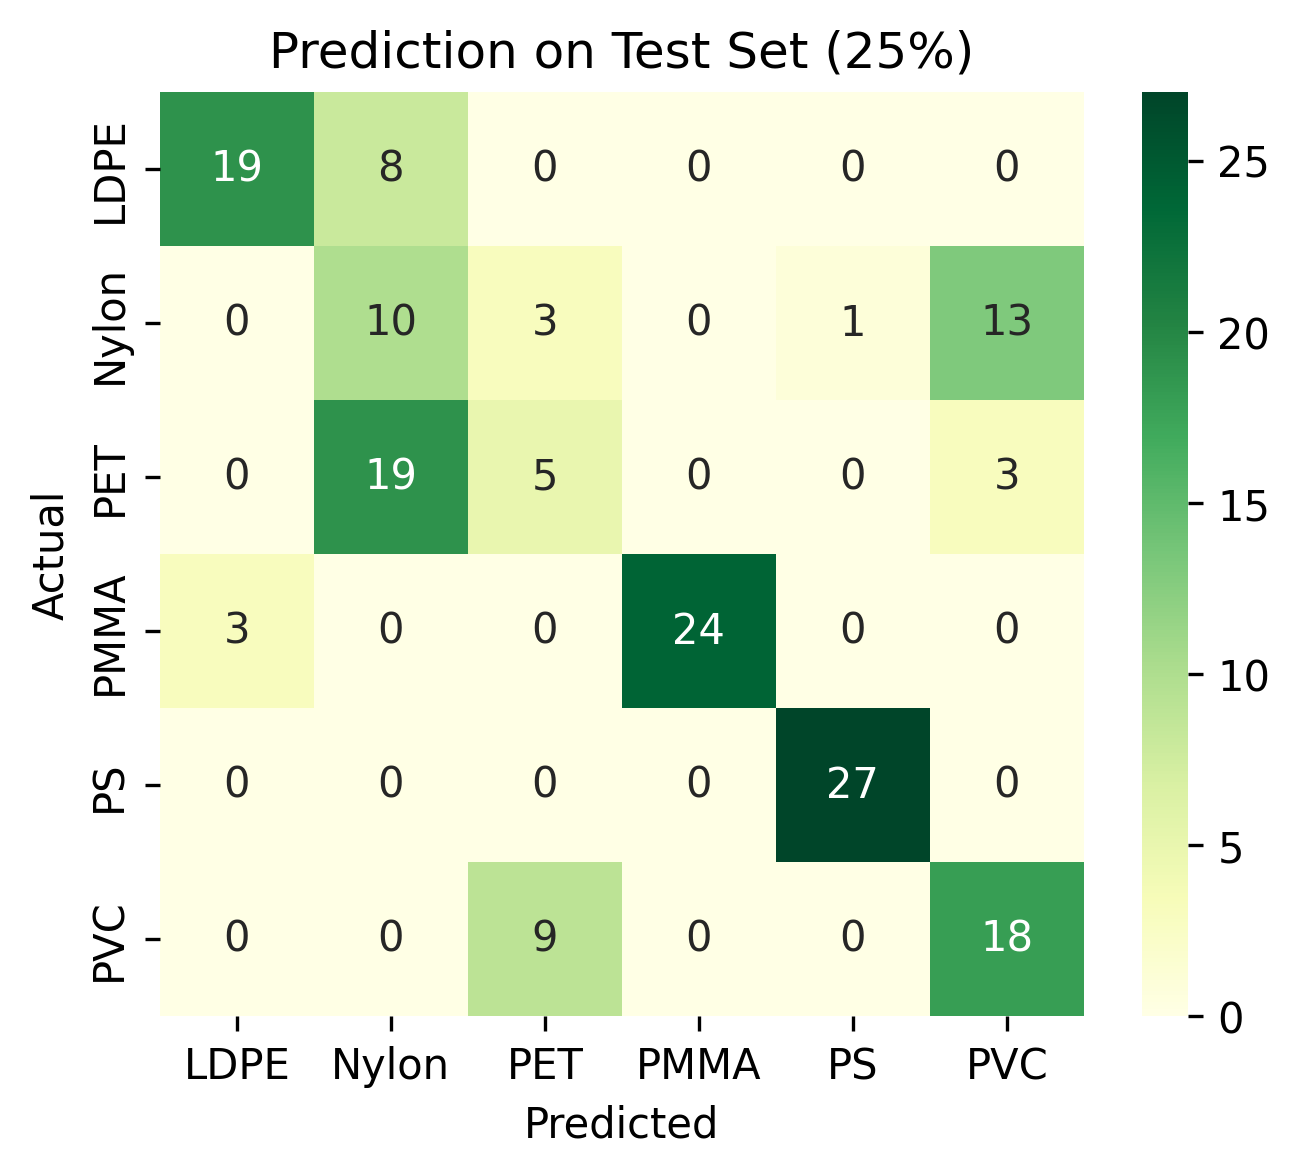

In [31]:
model = xgb.XGBClassifier(learning_rate=0.1, max_depth=6, subsample=1)
model.fit(X_train_new, y_train)
y_predict=model.predict(X_test_new)
scores = cross_val_score(estimator=model,X=X_train_new,y=y_train,cv=cv)
accuracy = accuracy_score(y_test,y_predict)

print(scores, accuracy)

#Draw a heatmap
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm1 = confusion_matrix(y_test, y_predict)

plt.figure(figsize=(5,4), dpi=300)
ax = sns.heatmap(cm1, annot=True, cmap="YlGn", square='True')
ax.set_title('Prediction on Test Set ({:.0%})'.format(test_size/ViewNum));
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in the same order as above (alphabetical order if resorted automatically)
ax.yaxis.set_ticklabels(labels, fontsize="10")
ax.xaxis.set_ticklabels(labels, fontsize="10")


## Display the visualization of the Confusion Matrix.
plt.show()


In [28]:
scores.mean(), scores.std()

(0.8933515674310962, 0.08749095101289545)

In [ ]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_max_depth',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'split5_test_score',
 'split6_test_score',
 'split7_test_score',
 'split8_test_score',
 'split9_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [ ]:
clf.best_params_

{'max_depth': 7}

In [ ]:
y_predict=clf.predict(X_test)
accuracy = accuracy_score(y_test,y_predict)
print(accuracy)

0.373015873015873


In [ ]:
dir(model)

['_Booster',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_is_fitted__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_request_for_signature',
 '_can_use_inplace_predict',
 '_check_feature_names',
 '_check_n_features',
 '_configure_fit',
 '_create_dmatrix',
 '_estimator_type',
 '_get_default_requests',
 '_get_iteration_range',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_get_type',
 '_load_model_attributes',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_set_evaluation_result',
 '_validate_data',
 '_validate_params',
 'apply',
 'base_score',
 'best_iteration',
 'best_sc

##Others

In [ ]:
len(xgb_cl.feature_importances_)

In [ ]:
from xgboost import plot_importance
# plot feature importance
plot_importance(xgb_cl)
plt.show()

In [ ]:
dir(xgb_cl)

In [ ]:
xgb_cl.feature_names_in_

In [ ]:
# Get a graph
graph = xgb.to_graphviz(xgb_cl, num_trees=5)
# Or get a matplotlib axis
ax = xgb.plot_tree(xgb_cl, num_trees=5)
# Get feature importances
xgb_cl.feature_importances_

In [ ]:
dataFrame = Data_Nofilter
#dataFrame = Data
#dataFrame = df_merge_NameReplaced

#Extract info from dataframe
#y is class
#x is an array of values in features
#display(dataFrame)
y = dataFrame['Class']
X = dataFrame.drop(["Class"], axis=1)
#display(X)
#X = X.values
#display(X)

#Preprocessing the classes info from string to number: encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
labels = list(le.classes_)
print("Classes are: ", labels)

#Shuffle-Split dataset into train and test
from sklearn.model_selection import train_test_split
test_size = 0.3
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                    random_state=random_state,
                                                    stratify=y) #Default shuffle=True

display(X_test)
from sklearn.metrics import accuracy_score
#init classifier
xgb_cl = xgb.XGBClassifier()

#Fit
xgb_cl.fit(X_train, y_train)

#Predic
#y_predict=xgb_cl.predict(X_test)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
shap_values = shap.TreeExplainer(xgb_cl).shap_values(X_train)

display(shap_values)

In [ ]:

shap.summary_plot(shap_values, X_train)

#A SHAP Example

In [ ]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 4.2 MB/s eta 0:00:00


In [ ]:
import shap
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl

ModuleNotFoundError: No module named 'shap'

In [ ]:
X,y = shap.datasets.nhanesi()
X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

In [ ]:
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgboost.train(params, xgb_train, 1000, evals = [(xgb_test, "test")], verbose_eval=100)

[0]	test-cox-nloglik:7.67904
[100]	test-cox-nloglik:7.45703
[200]	test-cox-nloglik:7.32699
[300]	test-cox-nloglik:7.23991
[400]	test-cox-nloglik:7.17889
[500]	test-cox-nloglik:7.13466
[600]	test-cox-nloglik:7.10170
[700]	test-cox-nloglik:7.07676
[800]	test-cox-nloglik:7.05775
[900]	test-cox-nloglik:7.04265
[999]	test-cox-nloglik:7.03047


In [ ]:
shap_values = shap.TreeExplainer(model_train).shap_values(X_train)
display(shap_values)

array([[ 1.0383745e-01, -3.6939675e-01, -1.0497979e-02, ...,
        -7.4444927e-02, -8.6218128e-03, -4.0220395e-03],
       [ 6.2932201e-02, -9.7667766e-01,  1.6067224e-02, ...,
        -8.6484803e-03, -3.2067432e-03, -3.9119478e-03],
       [-4.7239371e-02, -1.1039295e+00,  1.9171573e-02, ...,
        -5.8268860e-02, -2.3547921e-03, -4.0482795e-03],
       ...,
       [-7.1938813e-02, -7.1999460e-01,  1.8261040e-02, ...,
        -6.5546893e-02, -4.3529980e-03,  7.1786039e-02],
       [-1.3620624e-01,  4.0116876e-01, -1.9557210e-02, ...,
         1.6705365e-01, -1.4319870e-04, -6.8770754e-03],
       [ 6.2059455e-02, -1.1277987e+00, -7.9302881e-03, ...,
         7.5736515e-02,  1.8669170e-03, -1.2746304e-03]], dtype=float32)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


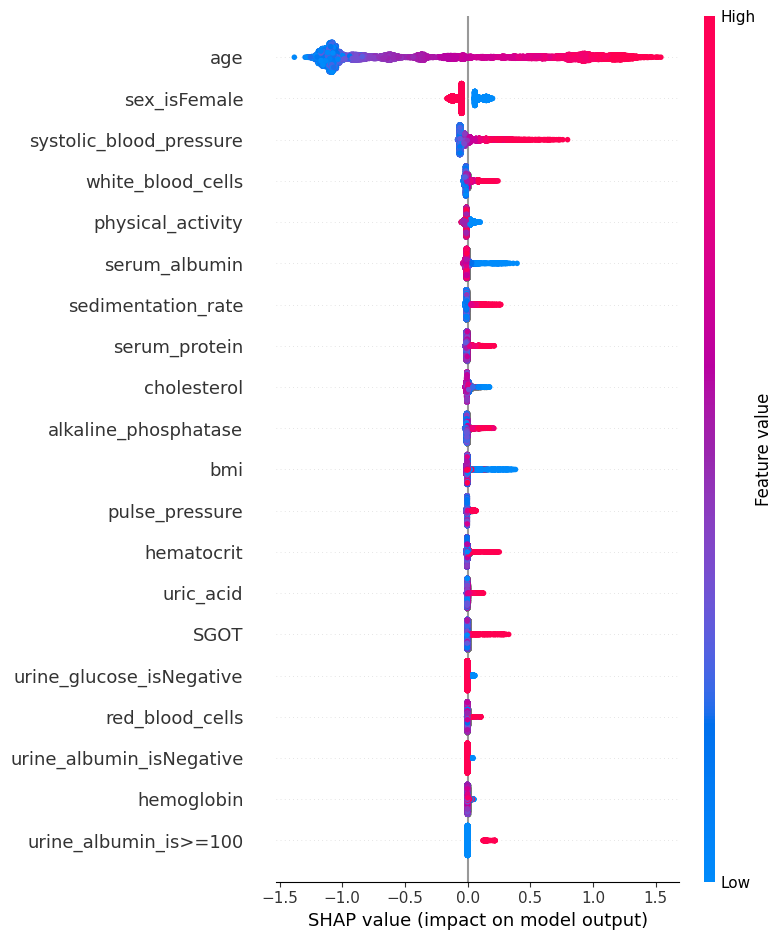

In [ ]:
shap.summary_plot(shap_values, X_train)

#Others

In [ ]:
pip install shap

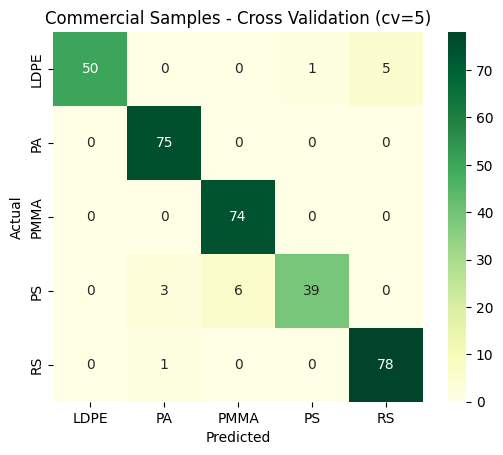

<Figure size 3300x2700 with 0 Axes>

In [ ]:
#Preprocessing the classes info from string to number: encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

pred = cross_val_predict(xgb_cl, x, y, cv=5)
cm1 = confusion_matrix(y, pred)

ax = sns.heatmap(cm1, annot=True, cmap="YlGn", square='True')
ax.set_title('Commercial Samples - Cross Validation (cv=5)');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in the same order as above (alphabetical order if resorted automatically)
ax.yaxis.set_ticklabels(labels, fontsize="10")
ax.xaxis.set_ticklabels(labels, fontsize="10")
plt.figure(figsize=(11, 9), dpi=300)

## Display the visualization of the Confusion Matrix.
plt.show()
#plt.savefig('1.png', transparent=True, bbox_inches='tight')

In [ ]:
folderpath="MachineLearningTest" #relative folderpath
#folder_path="/Users/macbookair2022/Google Drive/My Drive/Yisha/MNP/Data" absolute folderpath on Yisha mac
filenames = glob.glob(folderpath + "/*.xlsx")
print('File names:', filenames)


In [ ]:
vowel_change_case = {'A': 'a', 'E': 'e', 'I': 'i', 'O': 'o', 'U': 'u'}

text = "A dog named Abe does tricks"

text.translate(str.maketrans(vowel_change_case))

'a dog named abe does tricks'

In [ ]:
filenames =['MachineLearningTest/20230605-0615_5samples+4lights+12filters_ThresholdRGB.xlsx']
#filenames = ['MachineLearningTest/ThresholdRGB_no filter.xlsx']
#filenames = ['MachineLearningTest/20230707 grinded petri dish no filter glass slide_ThresholdRGB.xlsx']

# initializing empty data frame
df = pd.DataFrame()
Data = pd.DataFrame()

# to iterate excel file one by one inside the folder
for file in filenames:
    # combining multiple excel worksheets into single data frames
    print('Reading:', file)
    df = pd.concat(pd.read_excel(file, sheet_name=None, header=None, names=["Name", "R", "G", "B"]),
                   ignore_index=True, sort=False)
    Data = pd.concat([Data, df], ignore_index=True)

#to print the combined data
print('Merged Dataframe:')
display(Data)
#finalexcelsheet.to_excel(r'Final.xlsx', index=False)

In [ ]:
'''Modified for images without filter'''
# Extract sample, light and filter from filename and label every entry in dataframe
df = pd.DataFrame()
for Name in Data["Name"]:
    i = Name[:-4] #remove the last 4 character (.jpg)
    if len(i.split("_")) == 3:
        # Name = plastic+light+number
        a = i.split("_")[:2]
        a.append('N')
        a.append(i.split("_")[2])
    else: # Name = plastic+light+filter+number
        a = i.split("_")[:4]
    df = pd.concat([df, pd.DataFrame([a], columns=['Sample', 'Light', 'Filter', 'Repeat'])],
                   ignore_index=True)
display(df)
DataLabeled=pd.concat([Data, df], axis=1)
display(DataLabeled)

In [ ]:
'''Modified for images with sampler and no filter'''
# Extract sample, light and filter from filename and label every entry in dataframe
df = pd.DataFrame()
for Name in Data["Name"]:
    i = Name[:-4] #remove the last 4 character (.jpg)
    a = i.split("_")[:4]
    df = pd.concat([df, pd.DataFrame([a], columns=['Sample', 'Sampler', 'Light', 'Repeat'])],
                   ignore_index=True)
display(df)
DataLabeled=pd.concat([Data, df], axis=1)
display(DataLabeled)

In [ ]:
'''No Filter Version'''
csvname=folderpath + '/PetriTest.csv'

# RGB normalization
LightOption = ['G', 'B', 'UV', 'R'] # light source
LightRBGNorm = ['G', 'B', 'B', 'R', 'R', 'R'] # for each light, which RGB channel is for normalization
LightName = ['Green', 'Blue', 'UV', 'Red','NIR1', 'NIR2'] # for each light, which is for creating the figure

fignum=0
df_merge=pd.DataFrame()

# Loop in different lights
for k in range(len(LightOption)):
    df = pd.DataFrame()
    df = DataLabeled[(DataLabeled['Light'] == LightOption[k])]
    print('Analyzing:', LightName[k])
    RatioList=[]

    # RGB normalization
    for i in ['R','G','B']:
        denominator = LightRBGNorm[k]
        if i!=denominator:
            colname = LightOption[k] +'_' + i + '/'+denominator
            df[colname] = df[i]/df[denominator]
            RatioList.append(colname)
        #different way to add new column, didn't found a better way yet
        #factor = df[i]/df[denominator]
        #df.loc[:, colname] = factor
        #df=pd.concat([df, pd.DataFrame(factor, columns=[colname])], axis=1, ignore_index=True)
        #display(pd.DataFrame(factor, columns=[colname]))
    print('Done: RGB ratio versus', denominator, 'has been calculated!')
    #display(RatioList)

    # extract parameter columns
    df = (df.iloc[:, [4,7,8,9]]  #columns=sample, repeat, and two calculated parameters
          .reset_index(drop=True)
     )
    display(df)
    # merge the RGB results by sample
    if df_merge.empty:
        df_merge = df
    else:
        df_merge = df_merge.merge(df, on=['Sample', 'Repeat'])

display(df_merge)
df_merge = (df_merge.drop(columns='Repeat')
            .rename(columns={"Sample":"Class"})
           )

display(df_merge)

#Export results to csv
import os
os.makedirs(folderpath, exist_ok=True)
df_merge.to_csv(csvname, index=False)

In [ ]:
'''Filter Version'''
csvname=folderpath + '/MNP_filter.csv'

# RGB normalization
LightOption = ['G', 'B', 'UV', 'R'] # light source
LightRBGNorm = ['G', 'B', 'B', 'R', 'R', 'R'] # for each light, which RGB channel is for normalization
LightName = ['Green', 'Blue', 'UV', 'Red','NIR1', 'NIR2'] # for each light, which is for creating the figure

fignum=0
df_merge=pd.DataFrame()

# Loop in different lights
for k in range(len(LightOption)):
    df = pd.DataFrame()
    df = DataLabeled[(DataLabeled['Light'] == LightOption[k])]
    print('Analyzing:', LightName[k])
    RatioList=[]

    # RGB normalization
    for i in ['R','G','B']:
        denominator = LightRBGNorm[k]
        if i!=denominator:
            colname = LightOption[k] +'_' + i + '/'+denominator
            df[colname] = df[i]/df[denominator]
            RatioList.append(colname)
        #different way to add new column, didn't found a better way yet
        #factor = df[i]/df[denominator]
        #df.loc[:, colname] = factor
        #df=pd.concat([df, pd.DataFrame(factor, columns=[colname])], axis=1, ignore_index=True)
        #display(pd.DataFrame(factor, columns=[colname]))
    print('Done: RGB ratio versus', denominator, 'has been calculated!')
    #display(RatioList)

    # extract parameter columns
    df = (df.iloc[:, [4,6,7,8,9]]  #columns=sample, filter, repeat, and two calculated parameters
          .reset_index(drop=True)
     )
    # merge the RGB results by sample
    if df_merge.empty:
        df_merge = df
    else:
        df_merge = df_merge.merge(df, on=['Sample', 'Repeat', 'Filter'])

display(df_merge)
df_merge = df_merge.pivot_table(index=['Sample', 'Repeat'], columns='Filter')
df_merge.columns = ["_".join((i,j)) for i,j in df_merge.columns]
df_merge = (df_merge.reset_index(names=['Sample', 'Repeat'])
            .drop(columns='Repeat')
            .rename(columns={"Sample":"Class"})
           )

display(df_merge)

#Export results to csv
import os
os.makedirs(folderpath, exist_ok=True)
df_merge.to_csv(csvname, index=False)